# **Desafio Cientista de Dados - Indicium LightHouse**

**Tópicos neste notebook:**

5 - Data Preparation

6 - Feature Selection

7 - Machine Learning

8 - Fine Tunning

9 - Tradução e Interpretação do Erro

10 - Prevendo preço do imóvel solicitado

## Respostas das perguntas de Machine Learning

Os detalhes das respostas estão explicadas ao longo do notebook, aqui deixaria as respostas de forma resumida.

<br>

1- Explique como você faria a previsão do preço a partir dos dados. 

- Para criar uma solução de dados para o negócio, eu utilizei o método CRISP-DM que consiste, de forma macro, nas seguintes etapas: Entendimento do problema de negócio, Coleta de dados, Limpeza dos dados, Exploração dos dados (EDA), Modelagem dos dados, Machine Learning, Avaliação do modelo e Deploy do modelo.

<br>

2- Quais variáveis e/ou suas transformações você utilizou e por quê?

- Escolhi as variáveis: 'latitude', 'longitude', 'disponibilidade_365', 'distrito_Bronx', 'distrito_Brooklyn', 'distrito_Manhattan', 'distrito_Queens', 'room_type_Entire home/apt', 'room_type_Private room', 'reviews_por_mes', 'dias_desde_ultima_review', 'numero_de_reviews', 'host_total_listings', 'qnt_alug_possiv_por_ano', 'dias_alugados', 'minimo_noites', 'distrito_peso'.
Utilizei no rescaling: RobustScaler; No encoding: One Hot Encoding e Binary Encoding.

<br>

3- Qual tipo de problema estamos resolvendo (regressão, classificação)?

- Um problema de regressão, pois queremos prever um valor númerico, o preço.

<br>

4- Qual modelo melhor se aproxima dos dados e quais seus prós e contras?

- O modelo que mais se aproximou dos dados foi o XGBoost. O XGBoost é conhecido por seu desempenho superior em grandes conjuntos de dados, graças à sua capacidade de lidar eficientemente com complexidade. Ele oferece regularização integrada para evitar overfitting, suporta recursos avançados, como processamento paralelo e geralmente gera um modelo mais leve (armazenamento). No entanto, a configuração dos hiperparâmetros pode ser complexa e pode exigir mais recursos computacionais. Além disso, a interpretabilidade dos modelos XGBoost pode ser limitada devido à sua complexidade.

<br>

5- Qual medida de performance do modelo foi escolhida e por quê?

- Neste contexto de regressão/predição de preços, optei por utilizar as métricas MAE (Erro Absoluto Médio) e MAPE (Erro Percentual Absoluto Médio), pois elas se complementam. O MAPE fornece uma visão de quantos porcento, em média, o modelo está errando, enquanto o MAE representa essa porcentagem, mas em valor numérico do erro. Elas são medidas interessantes porque são simples e de fácil a comunicação com as partes interessadas do negócio.

# Imports

In [1]:
import pandas as pd
import numpy as np
import math
import random
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import xgboost as xgb
import plotly.express as px

from sklearn.preprocessing      import RobustScaler, MinMaxScaler, OrdinalEncoder, PolynomialFeatures, OneHotEncoder
from category_encoders          import TargetEncoder, BinaryEncoder
from sklearn.ensemble           import RandomForestRegressor, RandomForestClassifier
from boruta                     import BorutaPy
from sklearn.feature_selection  import SelectFromModel
from sklearn.metrics            import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, make_scorer
from sklearn.linear_model       import LinearRegression, Lasso
from sklearn.tree               import DecisionTreeRegressor
from sklearn.model_selection    import KFold
from matplotlib                 import gridspec

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore')

# Configurações Gerais
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
plt.rcParams['figure.figsize'] = [25, 12]
pd.set_option('display.float_format', '{:.2f}'.format)

# Helper Functions

In [2]:
# Funções para Avaliação dos Modelos
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}, index=[0])

def cross_validation(model_name, model_ml, X, y, kfolds, n_poly_degree=3):

    kf = KFold(n_splits=kfolds)

    mae_list = []
    mape_list = []
    rmse_list = []

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if model_name == 'Polynomial Regression':
            
            poly = PolynomialFeatures(degree=n_poly_degree, include_bias=False)
            X_poly_train = poly.fit_transform(X_train)
            X_poly_test = poly.transform(X_test)

            model = model_ml
            model.fit(X_poly_train, y_train)
            yhat = model.predict(X_poly_test)

        else:
            model_ml.fit(X_train, y_train)
            yhat = model_ml.predict(X_test)
            
        mae = mean_absolute_error(np.expm1(y_test), np.expm1(yhat))
        mape = mean_absolute_percentage_error(np.expm1(y_test), np.expm1(yhat))
        rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(yhat)))

        mae_list.append(mae)
        mape_list.append(mape)
        rmse_list.append(rmse)

    return pd.DataFrame( {'Model Name': model_name, 
                            'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 6).astype(str),
                            'MAPE CV': np.round(np.mean(mape_list), 3).astype(str) + ' +/- ' + np.round(np.std(mape_list), 6).astype(str),
                            'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 6).astype(str)}, index=[0])

# **5.0 Data Preparation**

In [3]:
# Dataset para feature selection - rescala e encoda todas as features, porém não salva especificamente para cada uma
df5 = pd.read_csv('../datasets/cooked_datasets/df3_processed.csv', low_memory = False)

# Dataset que recebe as apenas as feature selecionadas, estas serão rescaladas e encodadas, salvando separadamente cada uma. Colunas desnecessárias são dropadas. 
df_to_selected_features = pd.read_csv('../datasets/cooked_datasets/df3_processed.csv', low_memory = False)

Para garantir que os modelos de aprendizado de máquina possam entender e utilizar os dados de forma eficaz, aplicarei as seguintes etapas de pré-processamento.

**Rescaling (Redimensionamento):** Algoritmos de aprendizado de máquina podem ser afetados pela escala dos dados. Redimensionar os dados para uma escala específica garante que todos os atributos tenham a mesma importância no modelo.

**Encoding (Codificação):** Algoritmos de aprendizado de máquina não podem entender dados categóricos diretamente. A codificação converte esses dados em números, permitindo que os algoritmos os utilizem efetivamente.

**Transformação de Natureza:** Às vezes, os relacionamentos entre os atributos e a variável de destino não são simples. Aplicar transformações nos atributos pode ajudar a capturar melhor esses relacionamentos complexos, melhorando assim a precisão do modelo.

**Normalização usando log1p para a variável target:** Em algumas situações, a distribuição da variável target pode ser assimétrica. Usar a função log1p para normalizar a variável target pode ajudar a tornar a distribuição mais próxima de uma distribuição normal, o que pode melhorar o desempenho de certos modelos, especialmente os sensíveis à distribuição dos dados.

## 5.1 Normalização

Antes de aplicar a normalização com log1p, para normalizar a variável target atendendo uma das premissas do algoritmo de regressão, analisarei a distribuição do preço.

In [4]:
fig = px.box(df5, x='price', orientation='h')
fig.show()

In [5]:
# média de preço dentro do boxplot (sem outliers)
media_preco = df5[df5['price'] <= 339]
media_preco['price'].mean()

120.15917200054474

In [6]:
# Porcentagem de outliers em relação ao dataset
total_linhas = df5.shape[0]
outliers = df5[df5['price'] > 339].shape[0]
outliers/total_linhas

0.0611415128113333

Com base no boxplot acima, pude identificar interagindo com o gráfico que valores acima de 339 são considerados outliers, sendo assim, encontrei a média dos preços dentro do boxplot (sem outliers). Encontrei também a porcentagem que os outliers representam no dataset.

Neste primeiro ciclo, removerei os outliers para ver se melhora a performance do modelo, uma vez que representam apenas 6% e de acordo com o modelo de negócio, a média dos preços dentre os 94% do dataset é de 120.

In [7]:
# Removendo outliers df5
df5['price'] = df5['price'].apply(lambda x: 120 if x == 0 else 32 if x < 32 else x)
df5 = df5[df5['price'] <= 339]
df5.reset_index(drop=True, inplace=True)

# Removendo outliers df_to_selected_features
df_to_selected_features['price'] = df_to_selected_features['price'].apply(lambda x: 120 if x == 0 else 32 if x < 32 else x)
df_to_selected_features = df_to_selected_features[df_to_selected_features['price'] <= 339]
df_to_selected_features.reset_index(drop=True, inplace=True)

A seguir aplico log1p para normalizar a coluna price, atendendo premissas.

In [8]:
# Normalizando a var resposta 'price', atendendo a premissa ml.

# Para Feature selection
df5['price'] = np.log1p(df5['price'])

# Para treino e teste do modelo de predição
df_to_selected_features['price'] = np.log1p(df_to_selected_features['price'])

## 5.2 Rescaling

A seguir, verifiquei as colunas utilizando o boxplot e histplot, seguindo os conceitos abaixo, para decidir qual técnica de pré-processamento utilizarei em cada uma. Por fim, criei um tabela de resumo com as técnicas e que está presente no fim deste tópico. 


- Min-Max Scaler:
  - Transforma os dados para um intervalo específico, como (0, 1) ou (-1, 1).
  - Sensível à escala dos dados e pode ser influenciado por outliers.
  - Adequado para dados sem outliers significativos e distribuição aproximadamente normal.

- Robust Scaler:
  - Dimensiona os dados usando estatísticas robustas para evitar influência de outliers.
  - É uma escolha segura quando há presença de outliers ou quando a distribuição dos dados é desconhecida.

- Standard Scaler:
  - Padroniza os dados para que tenham média zero e desvio padrão de 1.
  - Sensível à escala dos dados, mas não é afetado por outliers.
  - Útil quando os dados têm diferentes escalas e distribuições, e você deseja garantir que todas as features tenham a mesma escala.


<Axes: xlabel='latitude', ylabel='Count'>

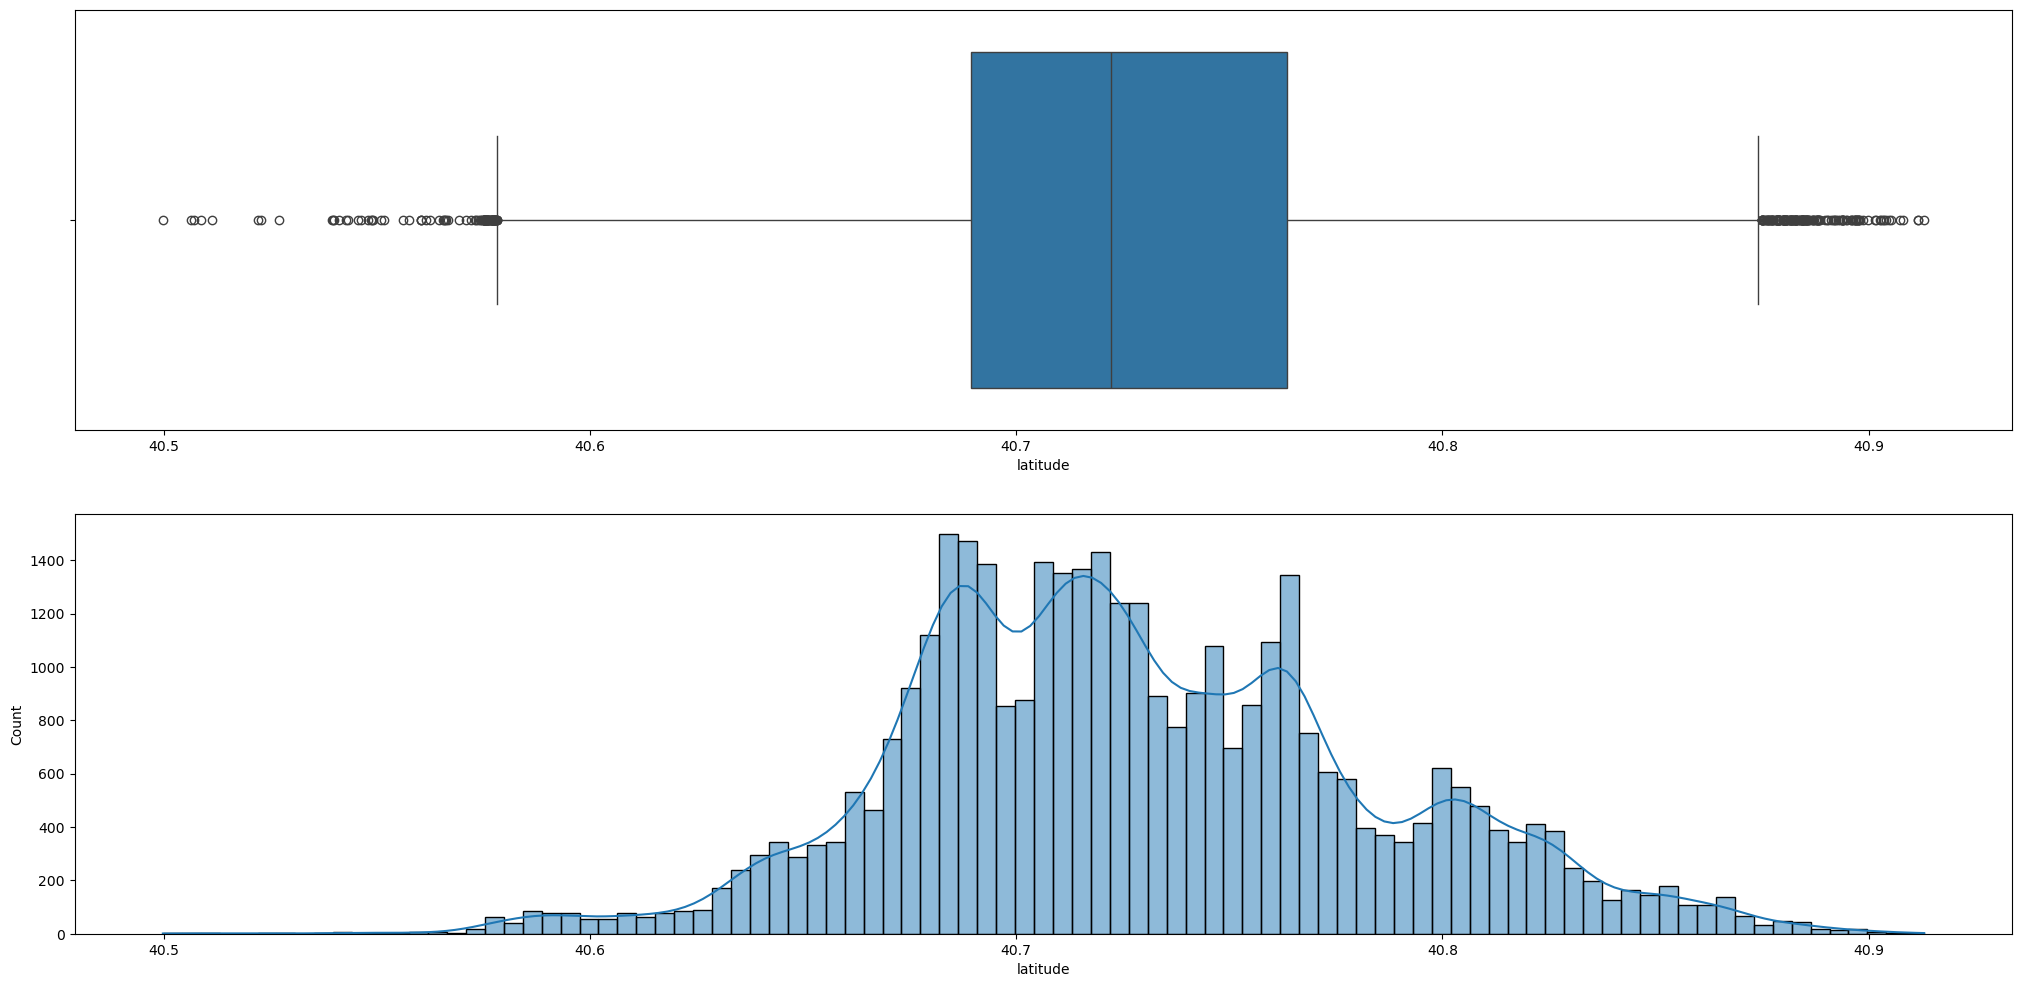

In [9]:
plt.subplot(2,1,1)
sns.boxplot(x=df5['latitude'])

plt.subplot(2,1,2)
sns.histplot(df5['latitude'], kde=True)

Presença de Outliers, curva não claramente normal e não unimodal, logo, RobustScaler.

<Axes: xlabel='longitude', ylabel='Count'>

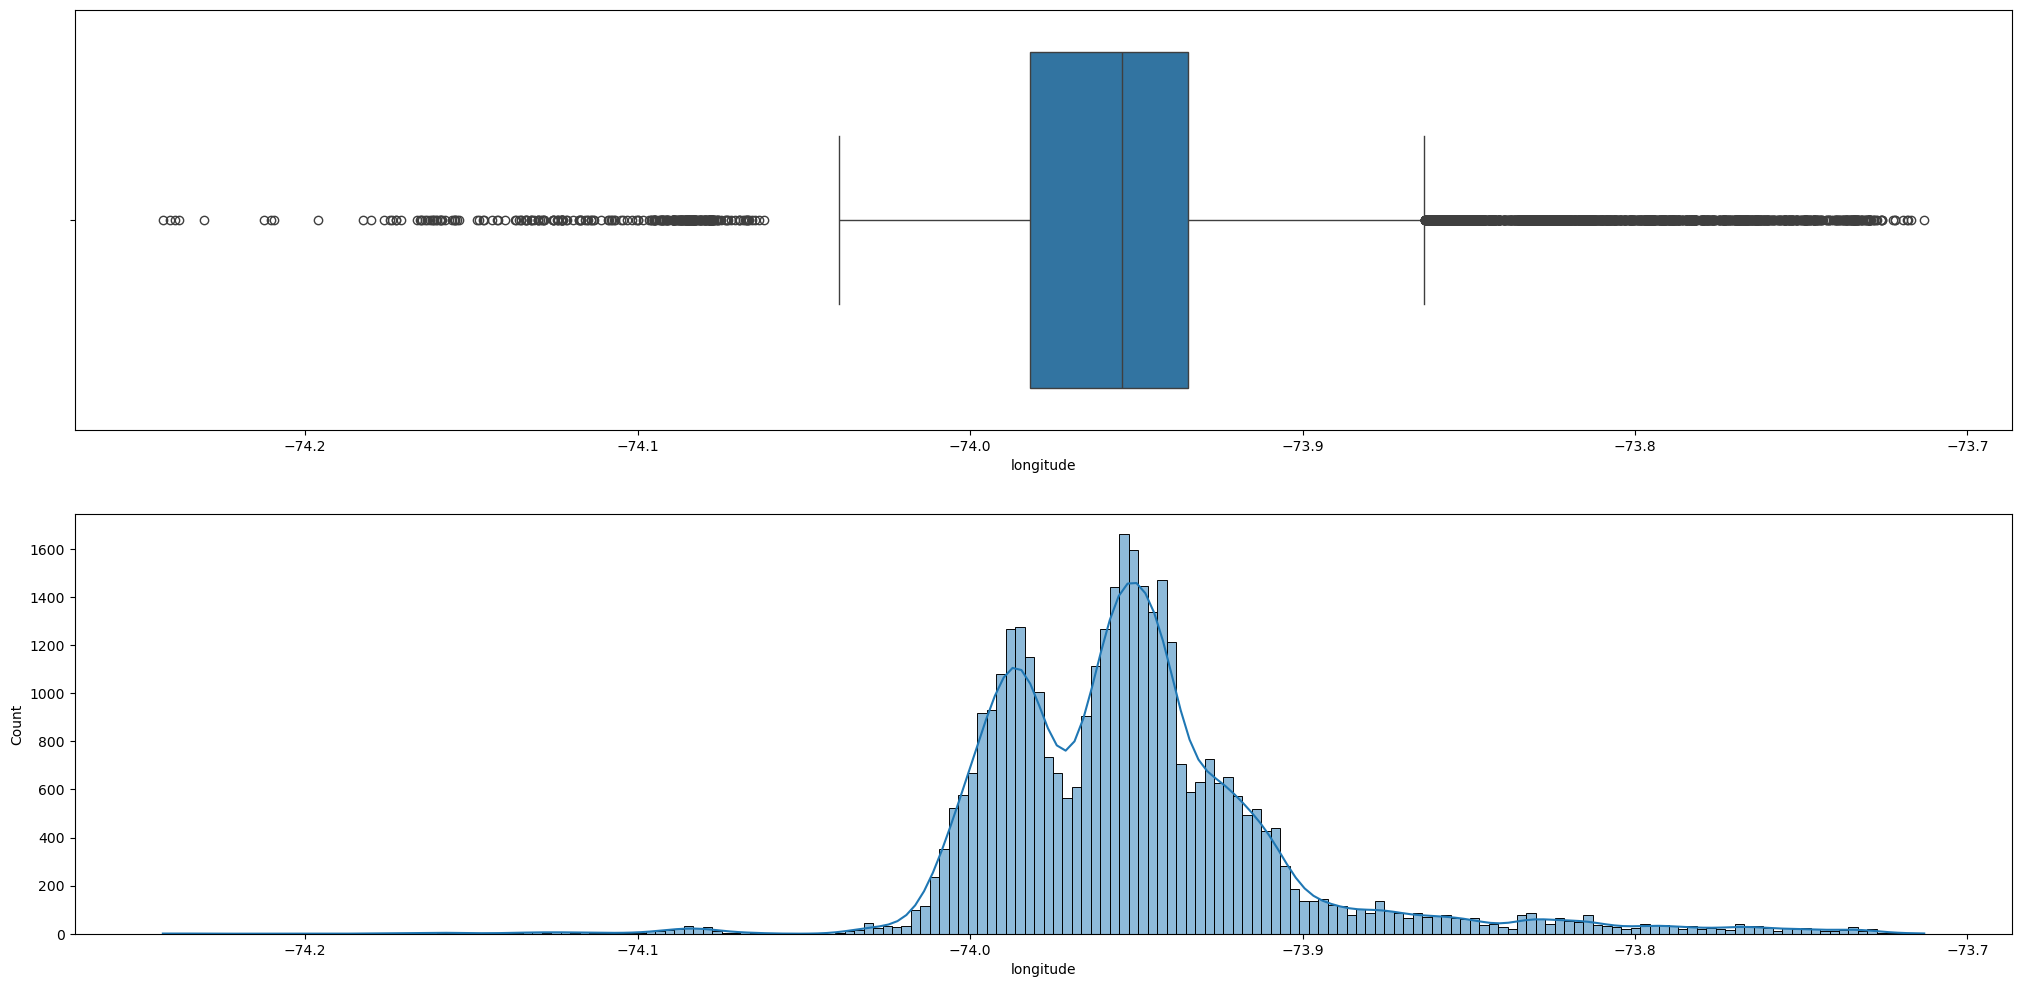

In [10]:
plt.subplot(2,1,1)
sns.boxplot(x=df5['longitude'])

plt.subplot(2,1,2)
sns.histplot(df5['longitude'], kde=True)

Presença de Outliers, curva não claramente normal e não unimodal, logo, RobustScaler.

<Axes: xlabel='minimo_noites', ylabel='Count'>

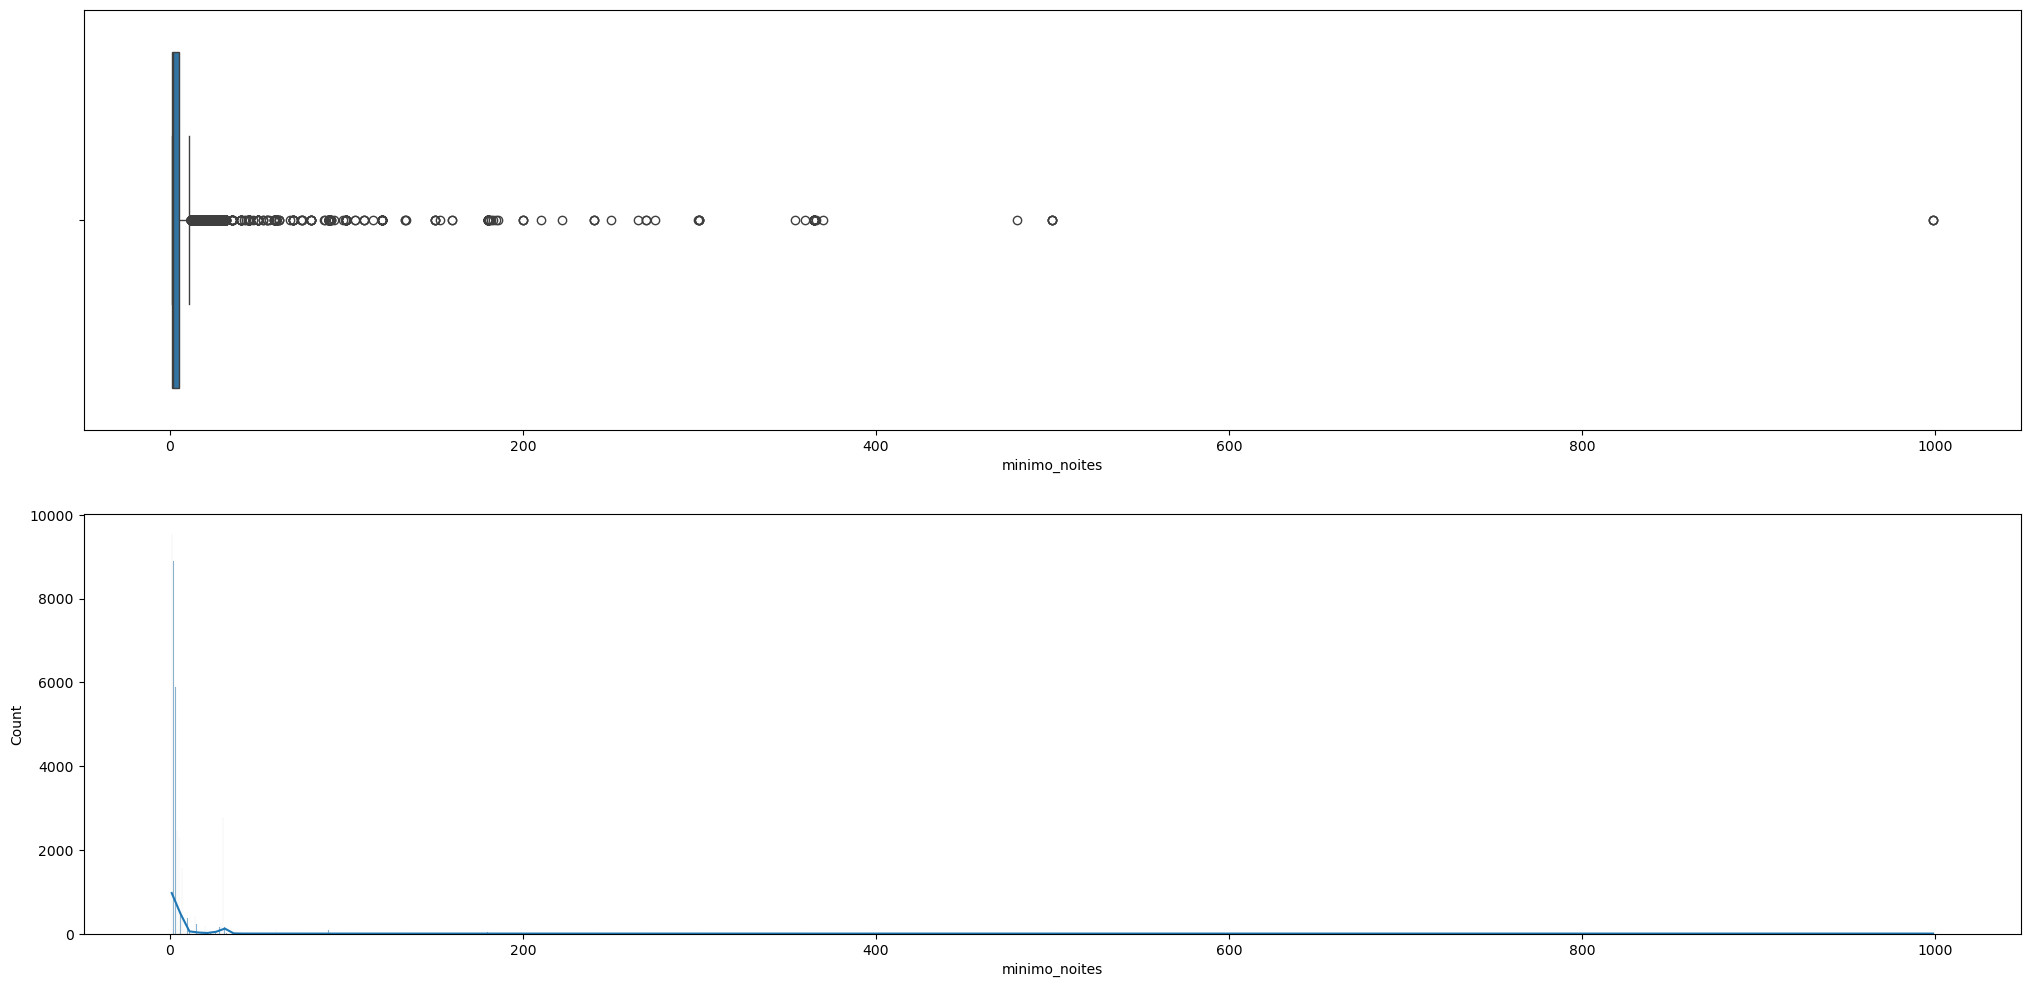

In [11]:
plt.subplot(2,1,1)
sns.boxplot(x=df5['minimo_noites'])

plt.subplot(2,1,2)
sns.histplot(df5['minimo_noites'], kde=True)

Presença de Outliers, curva não normal, logo, RobustScaler.

<Axes: xlabel='numero_de_reviews', ylabel='Count'>

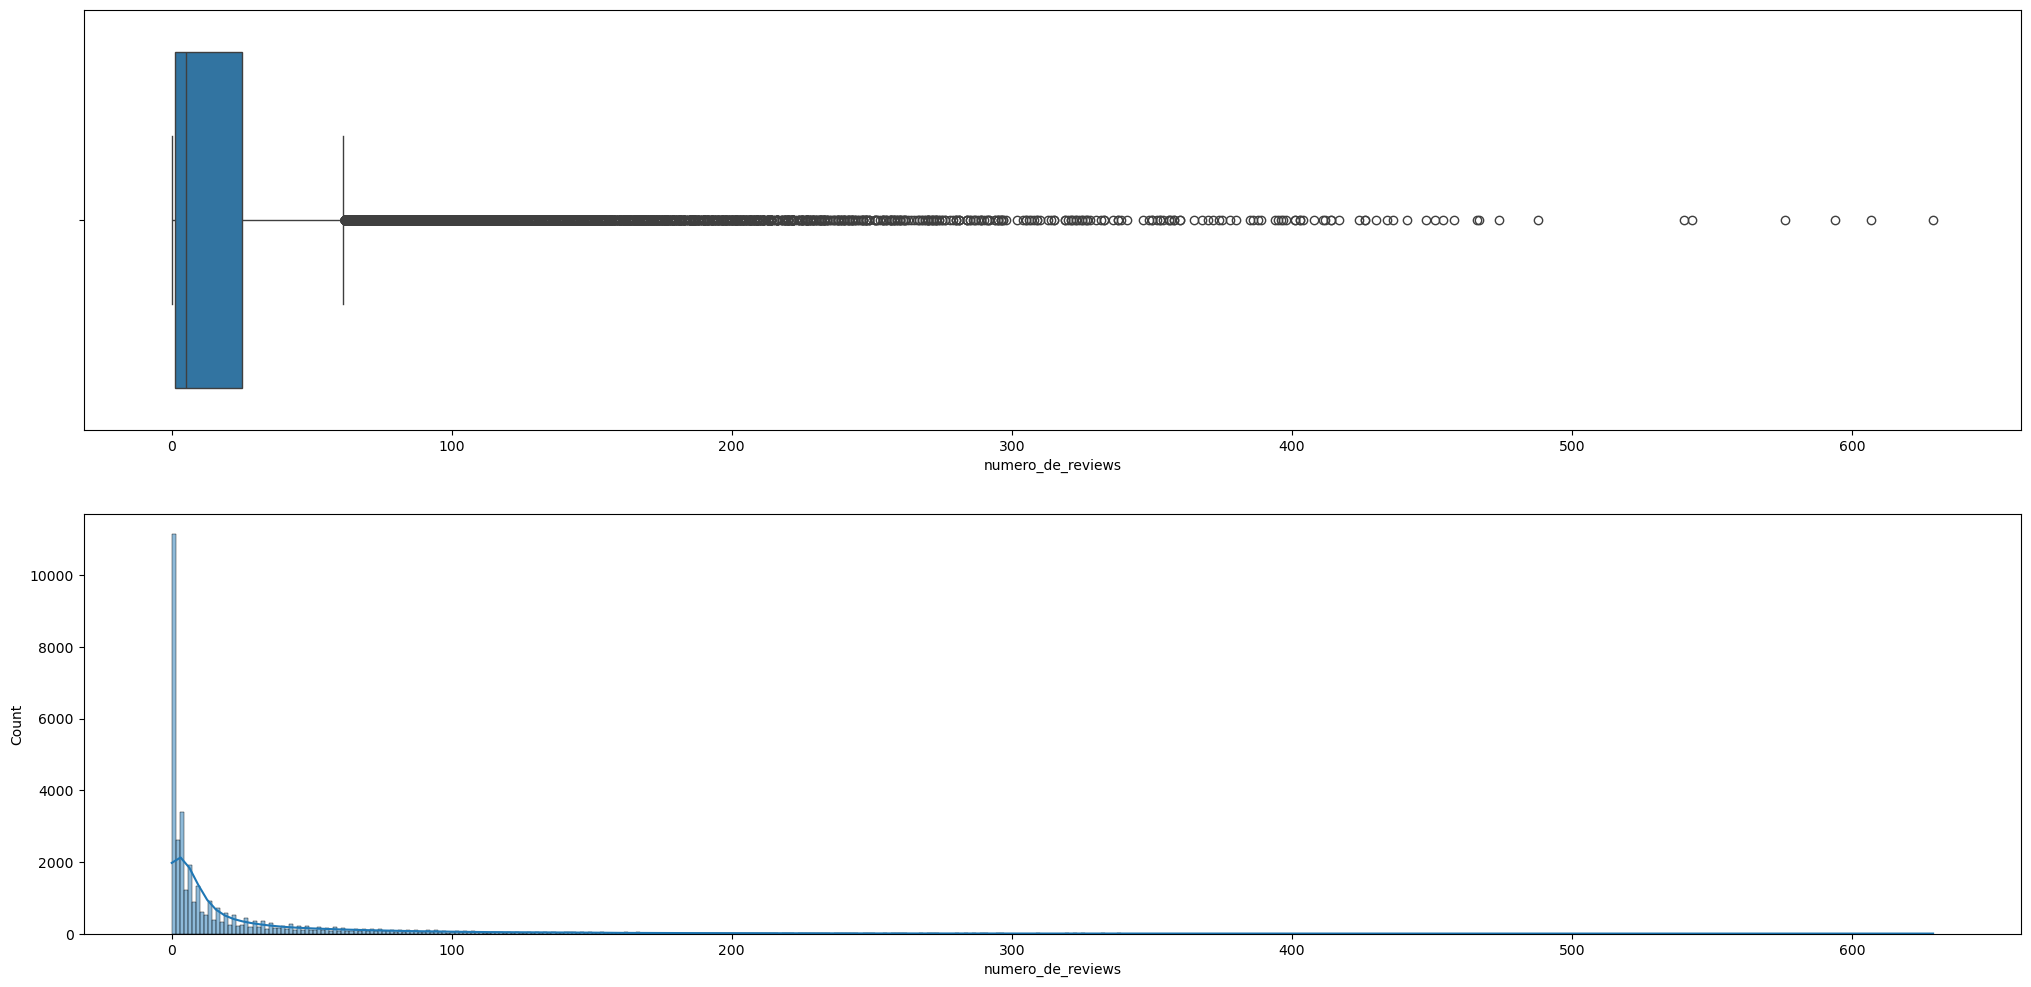

In [12]:
plt.subplot(2,1,1)
sns.boxplot(x=df5['numero_de_reviews'])

plt.subplot(2,1,2)
sns.histplot(df5['numero_de_reviews'], kde=True)

Presença de Outliers, curva não normal, logo, RobustScaler.

<Axes: xlabel='reviews_por_mes', ylabel='Count'>

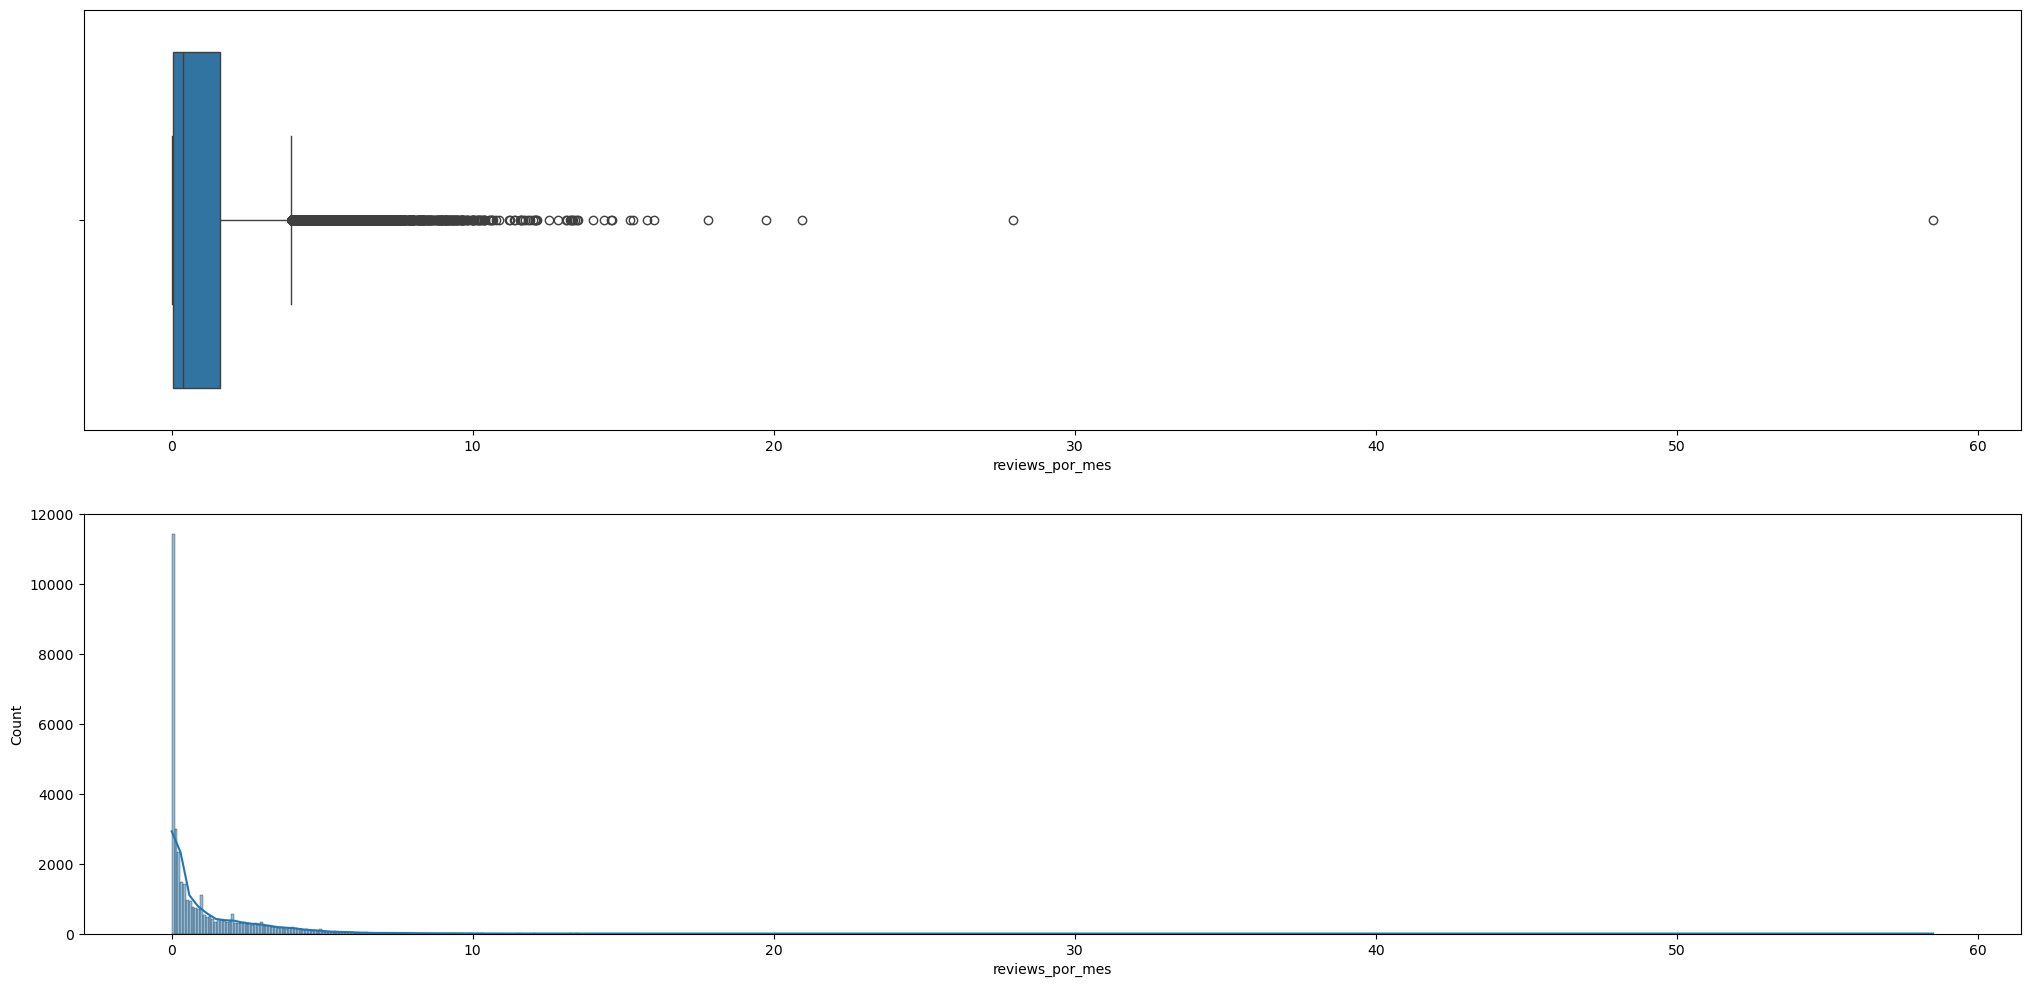

In [13]:
plt.subplot(2,1,1)
sns.boxplot(x=df5['reviews_por_mes'])

plt.subplot(2,1,2)
sns.histplot(df5['reviews_por_mes'], kde=True)

Presença de Outliers, curva não normal, logo, RobustScaler.

<Axes: xlabel='host_total_listings', ylabel='Count'>

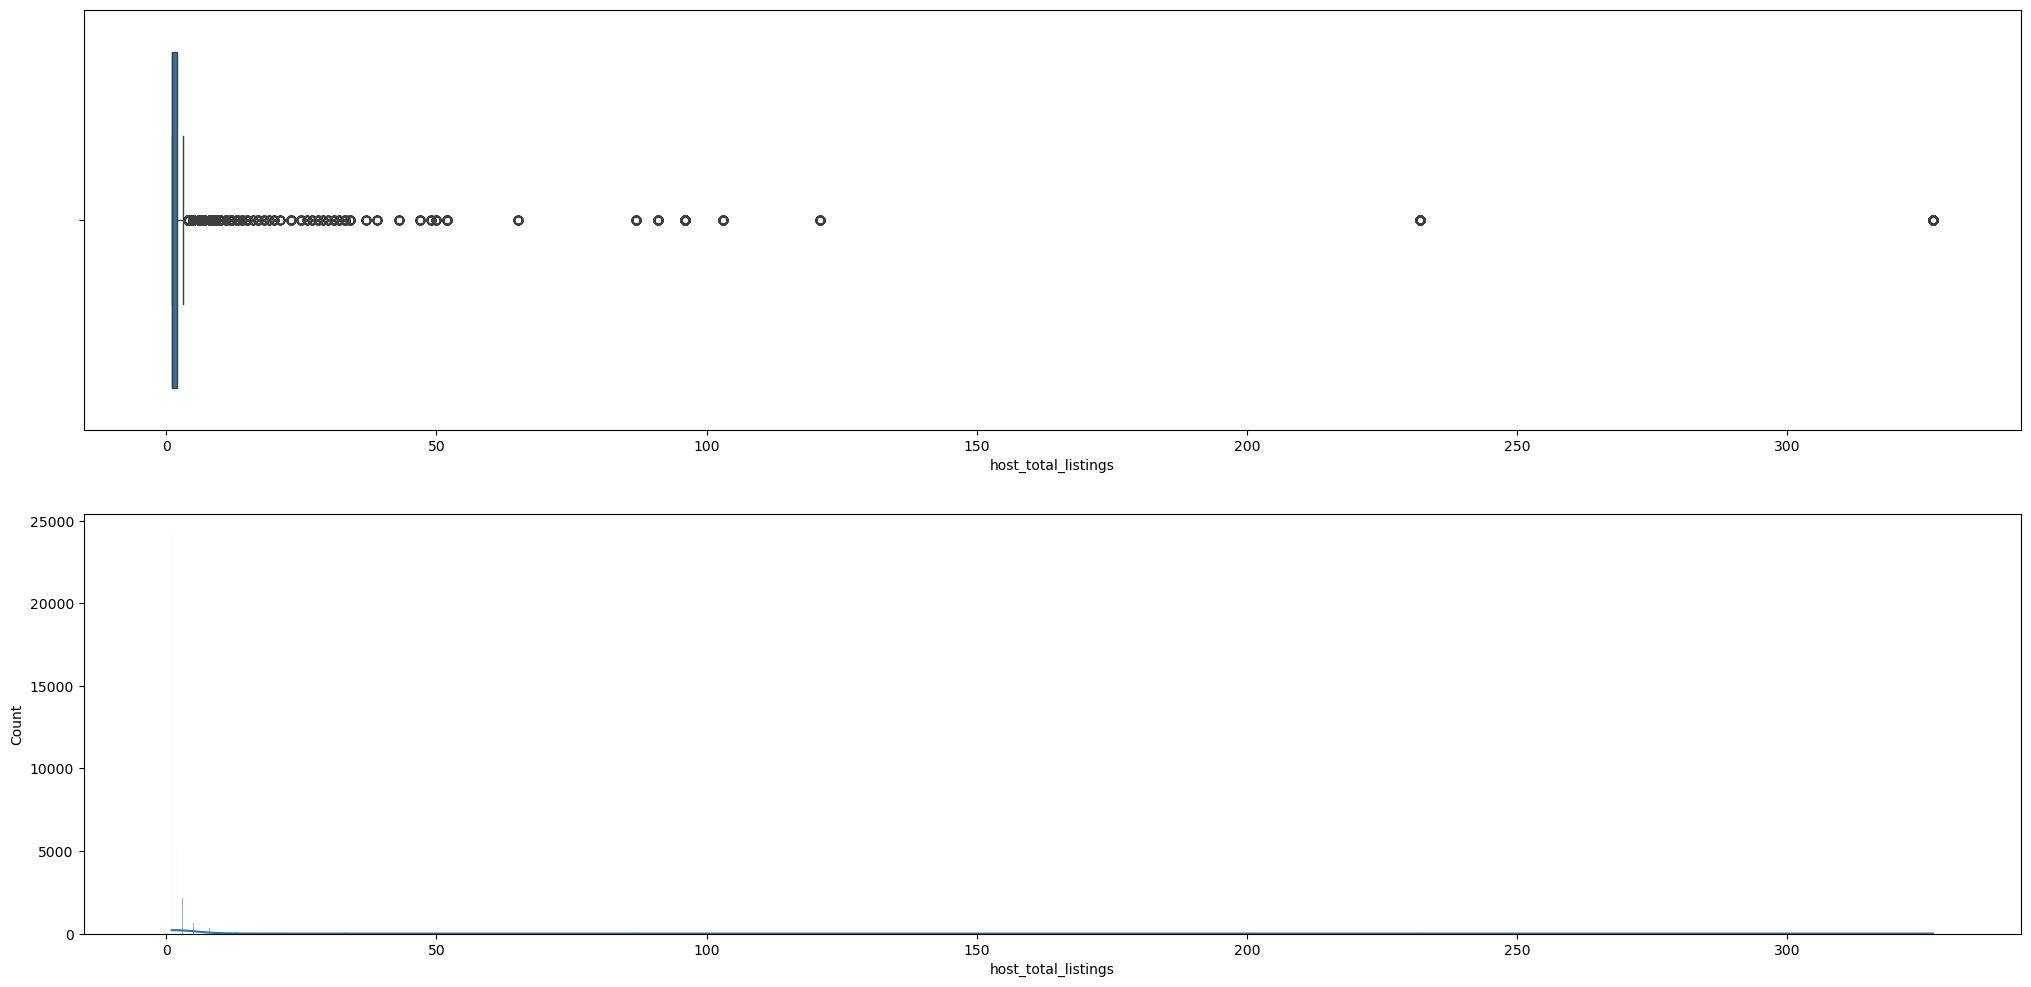

In [14]:
plt.subplot(2,1,1)
sns.boxplot(x=df5['host_total_listings'])

plt.subplot(2,1,2)
sns.histplot(df5['host_total_listings'], kde=True)

Presença de Outliers, curva não normal, logo, RobustScaler.

<Axes: xlabel='disponibilidade_365', ylabel='Count'>

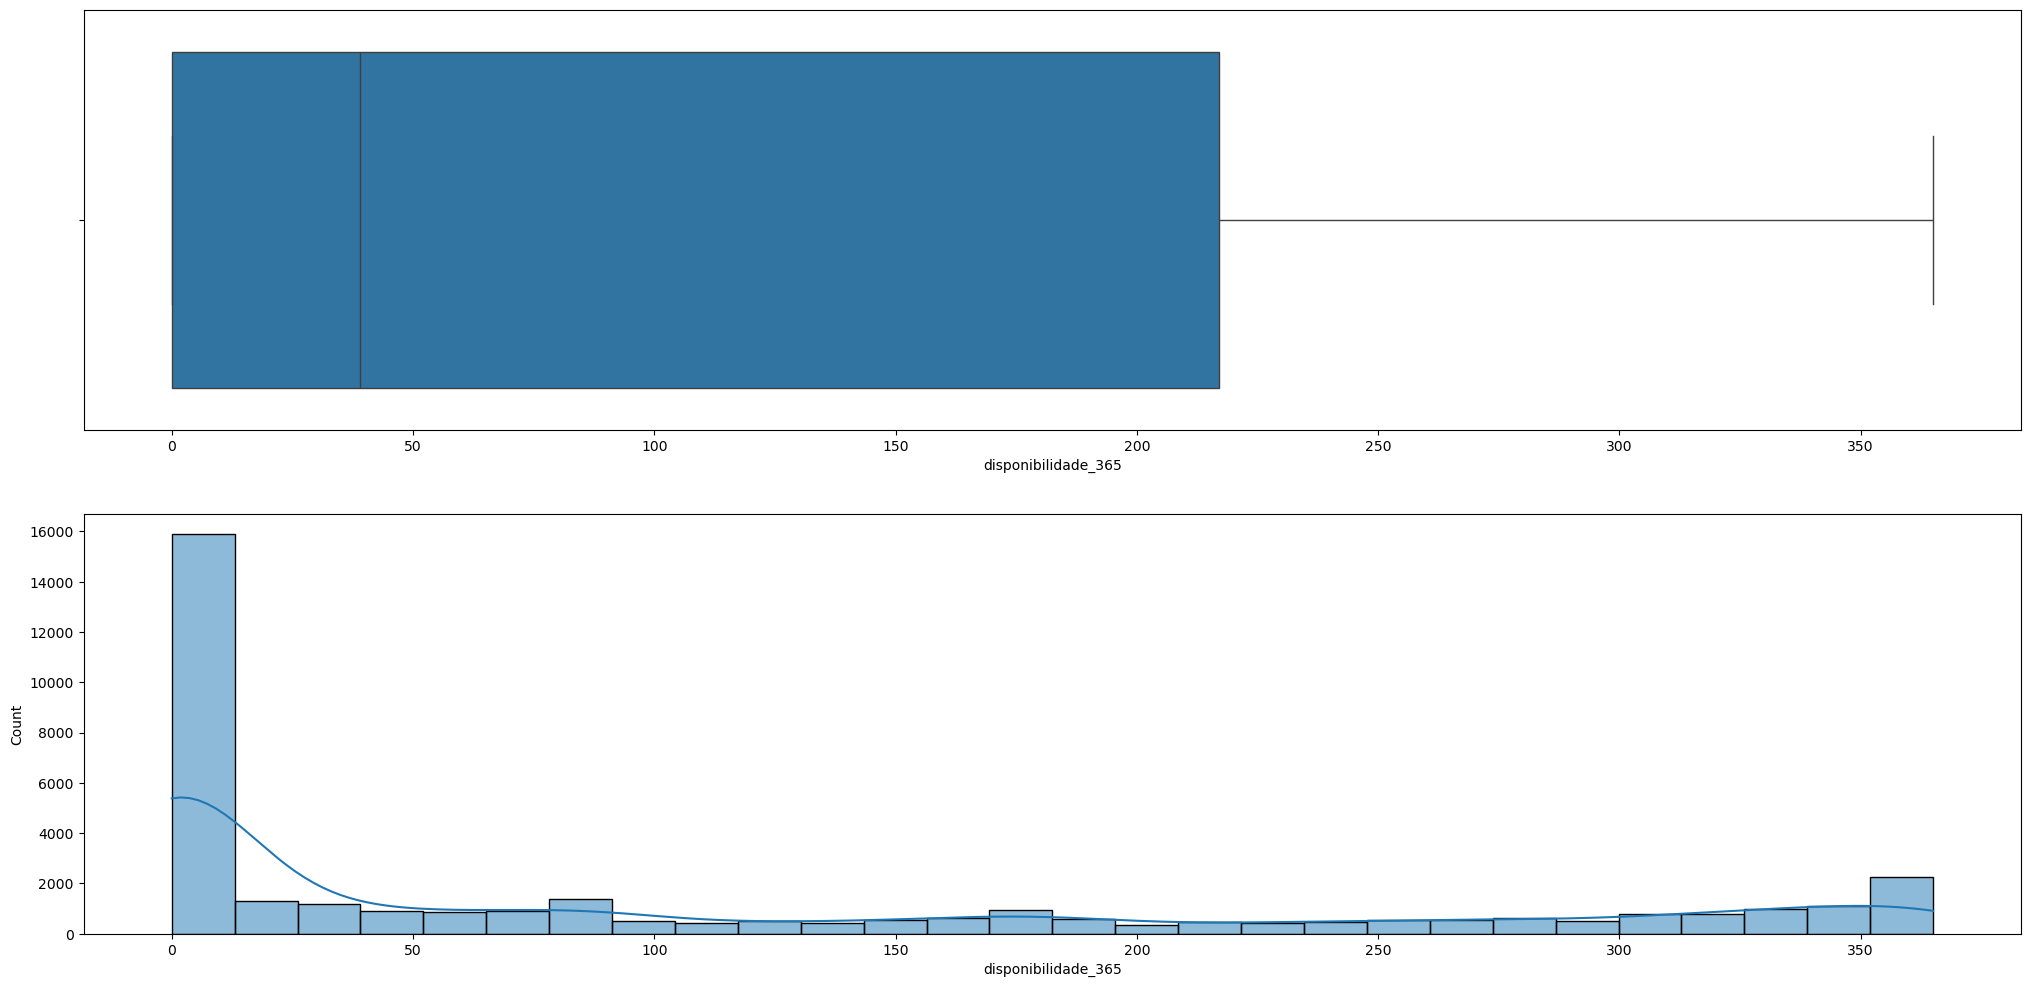

In [15]:
plt.subplot(2,1,1)
sns.boxplot(x=df5['disponibilidade_365'])

plt.subplot(2,1,2)
sns.histplot(df5['disponibilidade_365'], kde=True)

Neste caso, as distribuição não possui outliers, mas não é uma curva normal, sendo assim, devo utilizar o RobustScaler.

<Axes: xlabel='ano', ylabel='Count'>

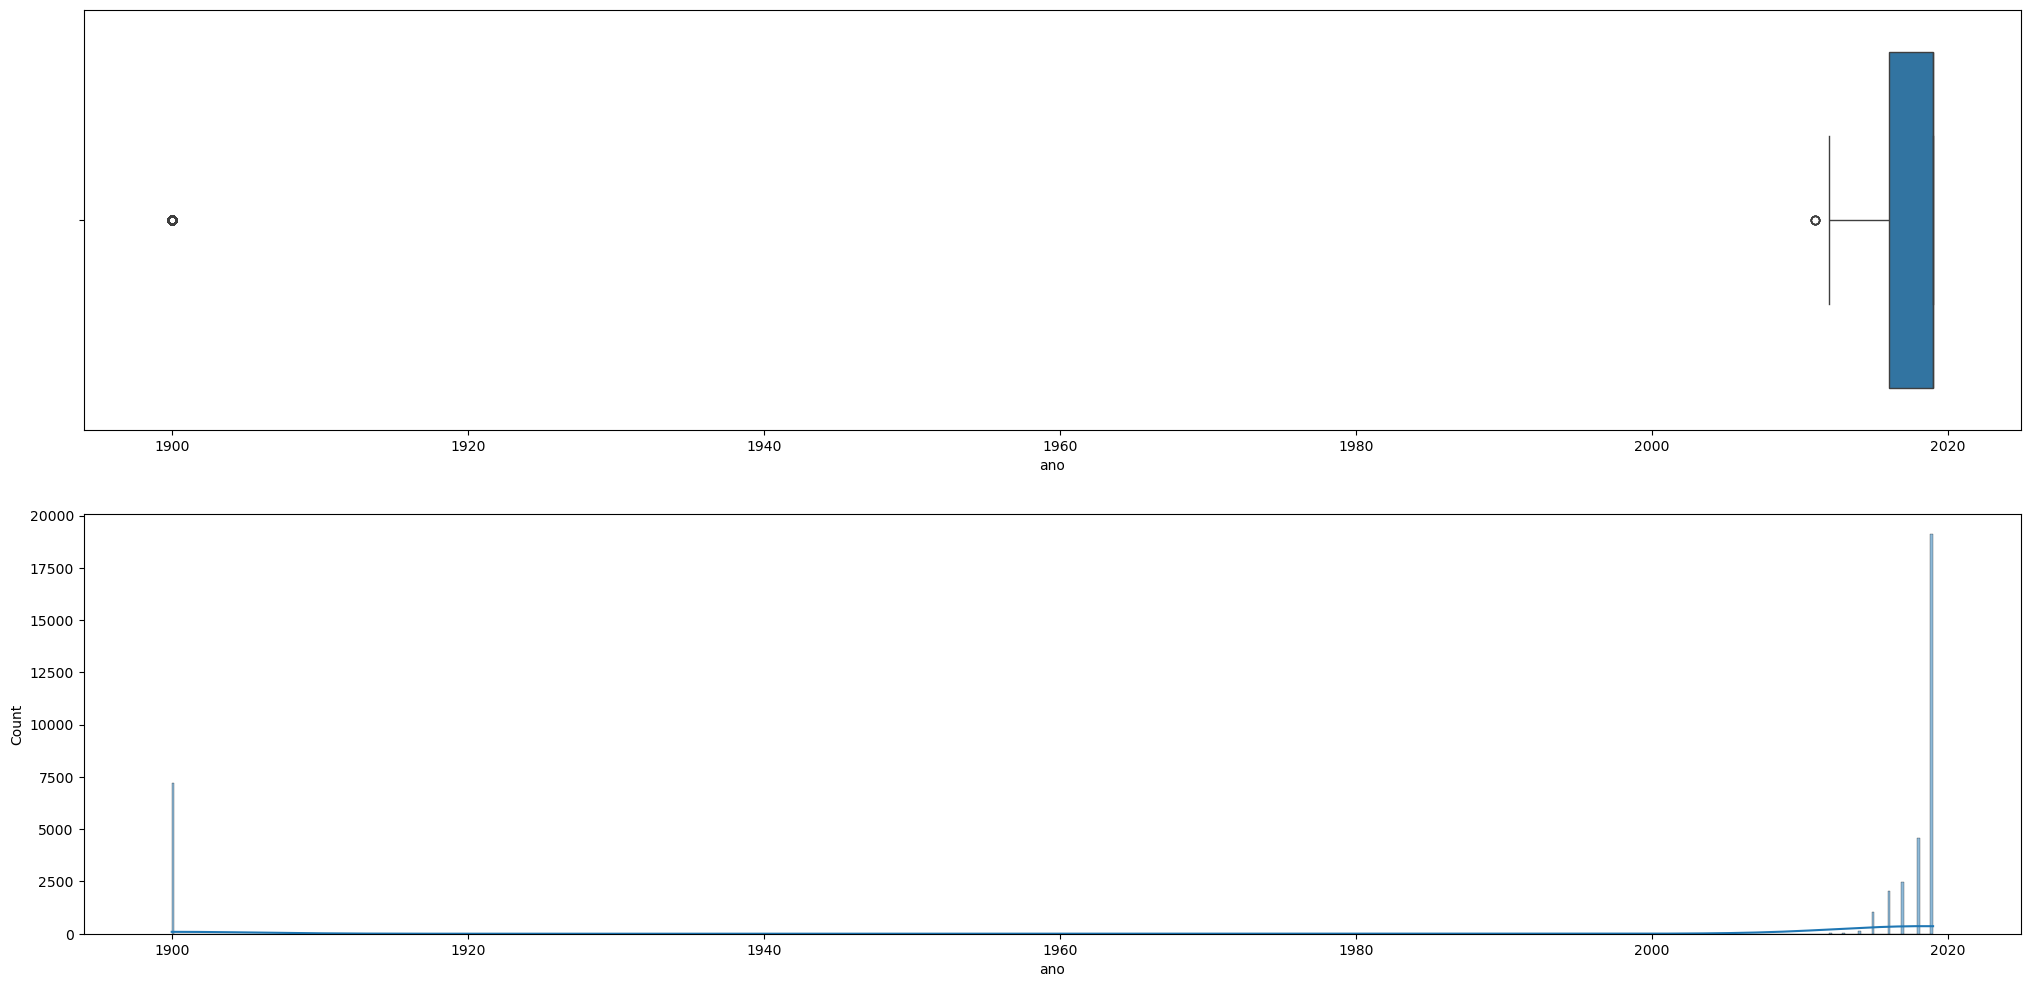

In [16]:
plt.subplot(2,1,1)
sns.boxplot(x=df_to_selected_features['ano'])

plt.subplot(2,1,2)
sns.histplot(df_to_selected_features['ano'], kde=True)

<Axes: xlabel='ano', ylabel='Count'>

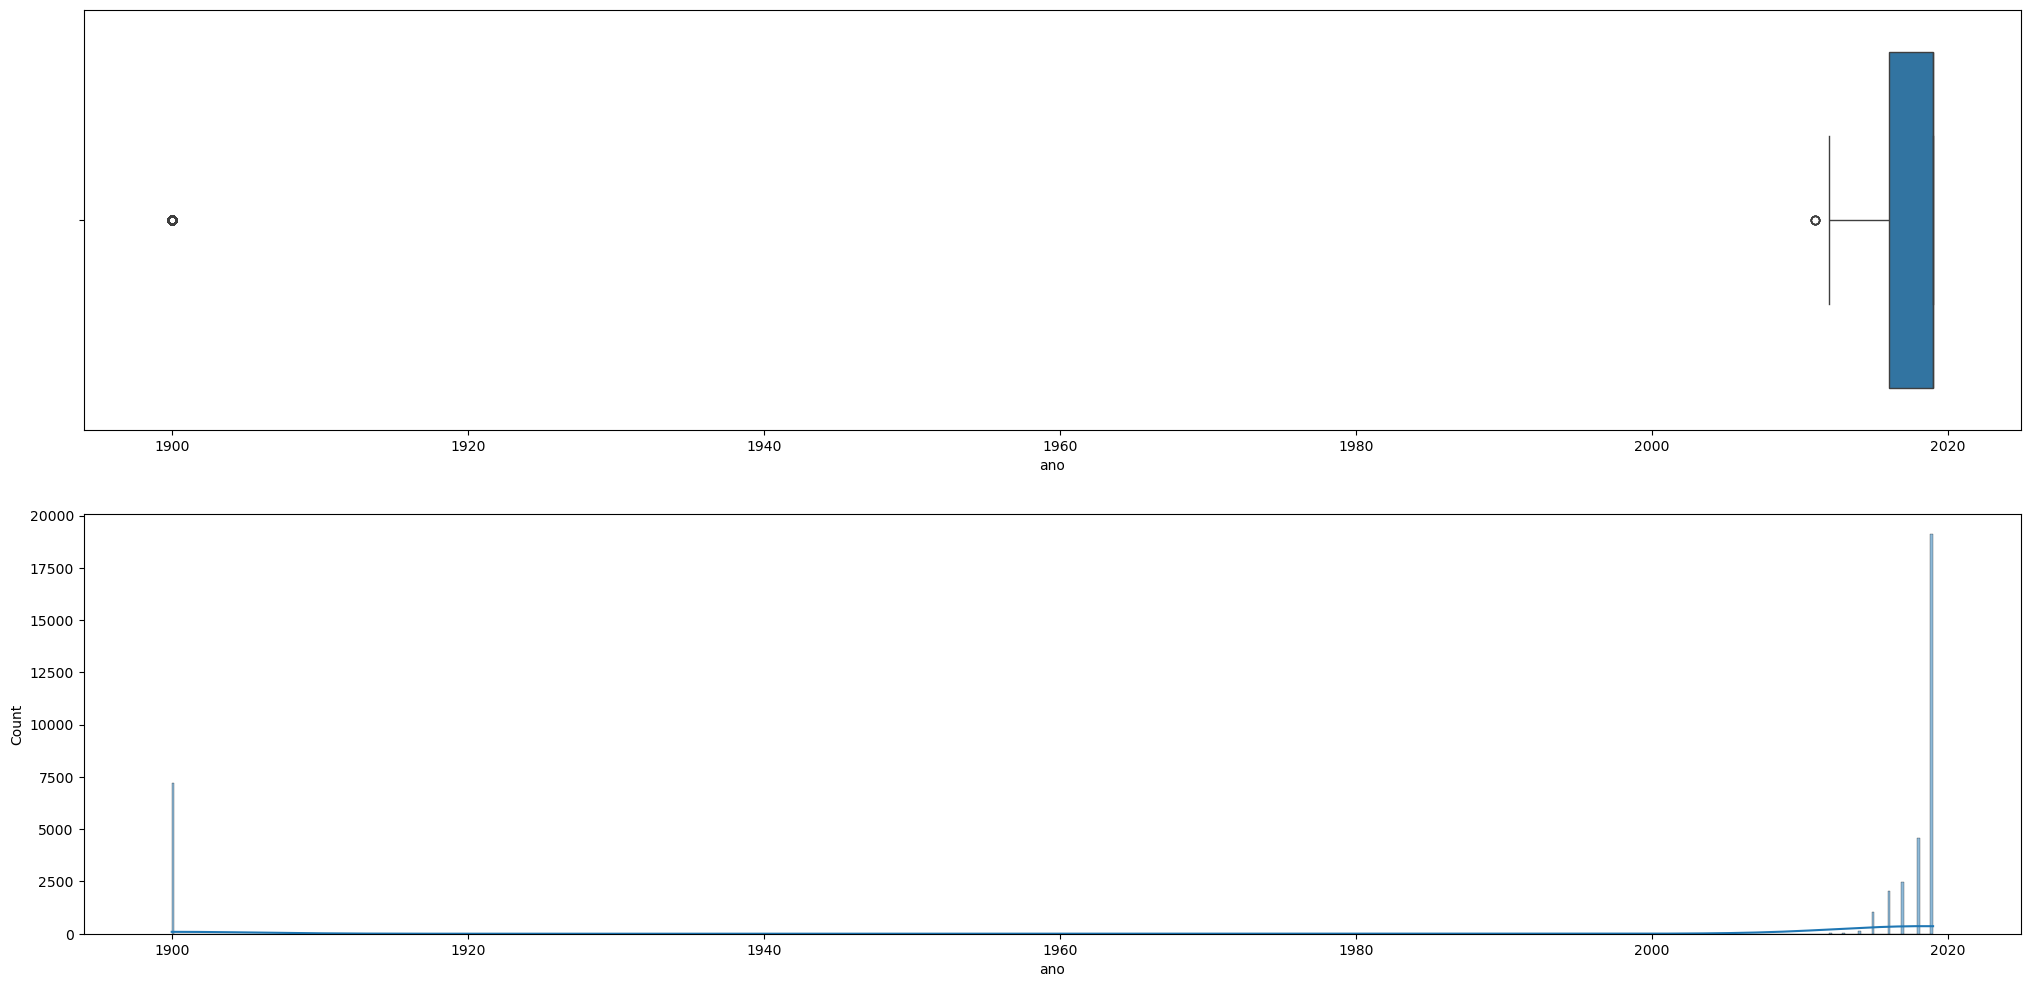

In [17]:
plt.subplot(2,1,1)
sns.boxplot(x=df5['ano'])

plt.subplot(2,1,2)
sns.histplot(df5['ano'], kde=True)

Presença de Outliers, curva não normal, logo, RobustScaler.

<Axes: xlabel='dias_desde_ultima_review', ylabel='Count'>

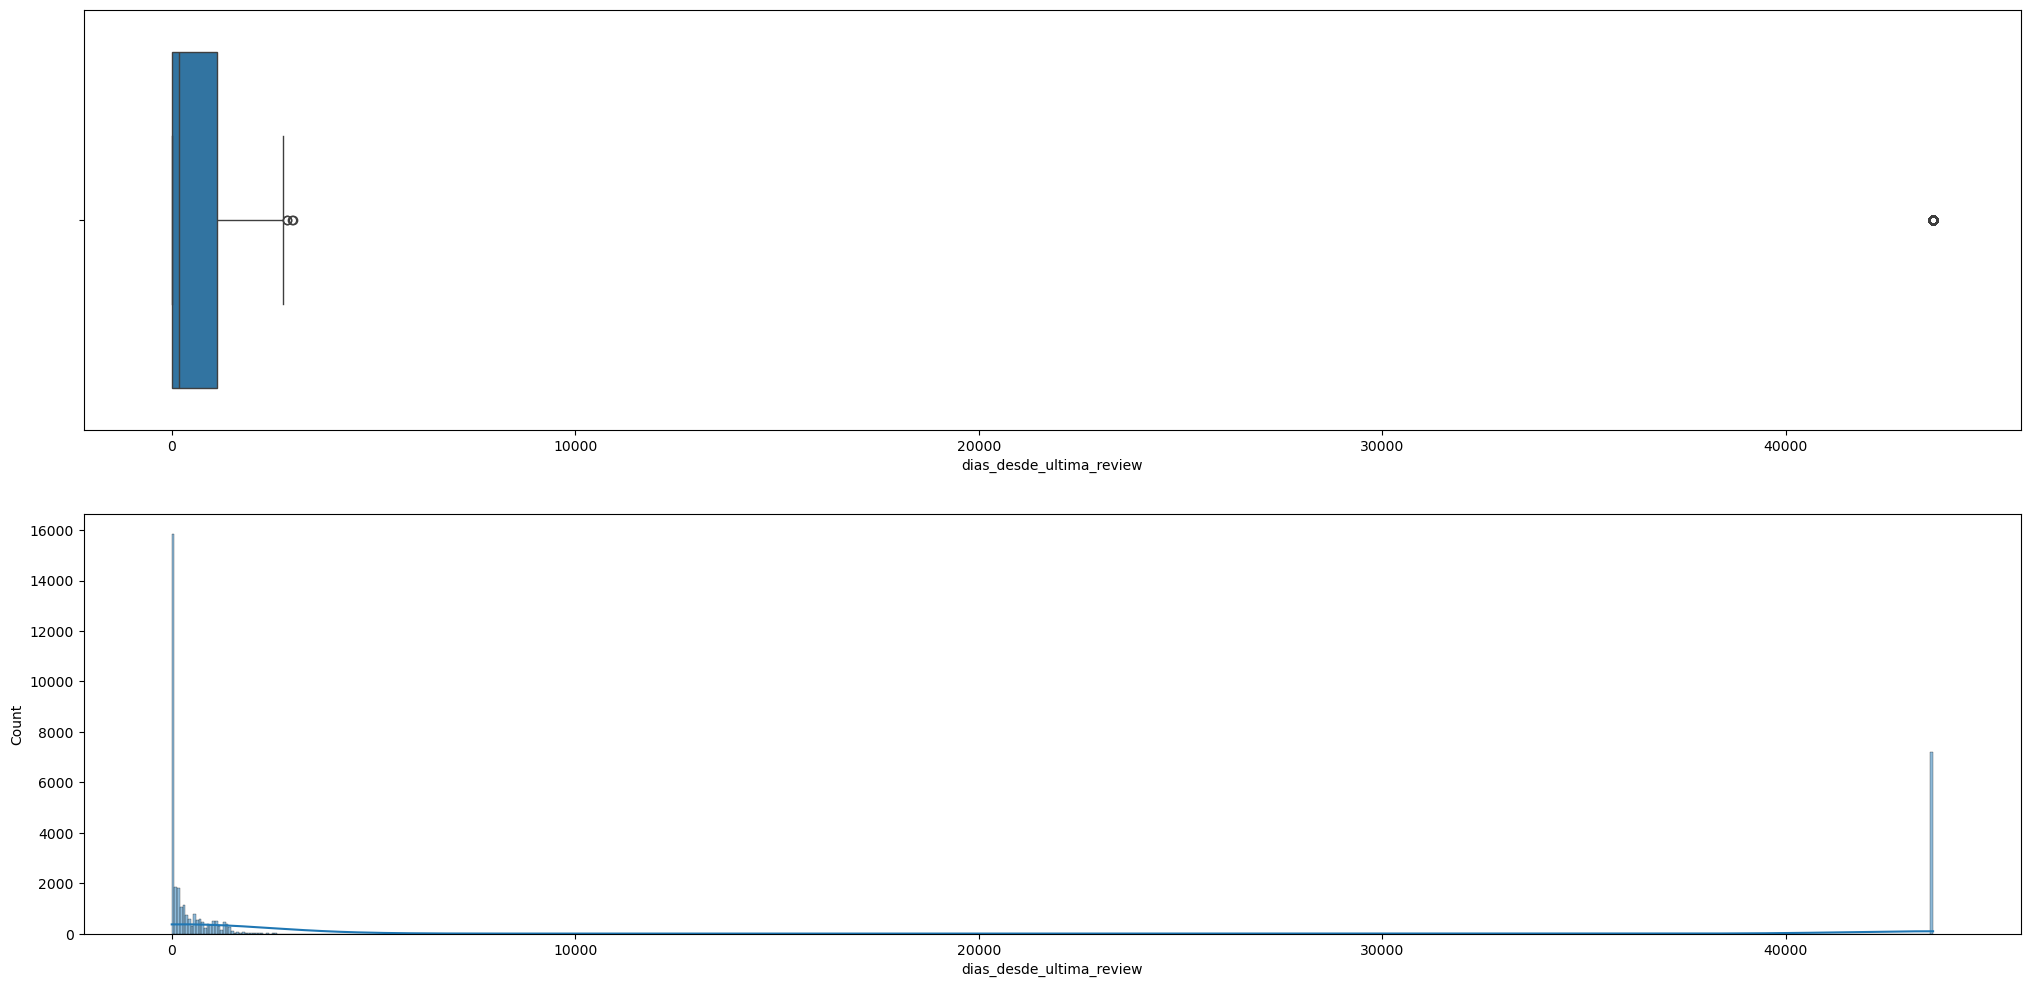

In [18]:
plt.subplot(2,1,1)
sns.boxplot(x=df5['dias_desde_ultima_review'])

plt.subplot(2,1,2)
sns.histplot(df5['dias_desde_ultima_review'], kde=True)

Presença de outliers, distribuição não normal, Robust Scaler.

<Axes: xlabel='qnt_alug_possiv_por_ano', ylabel='Count'>

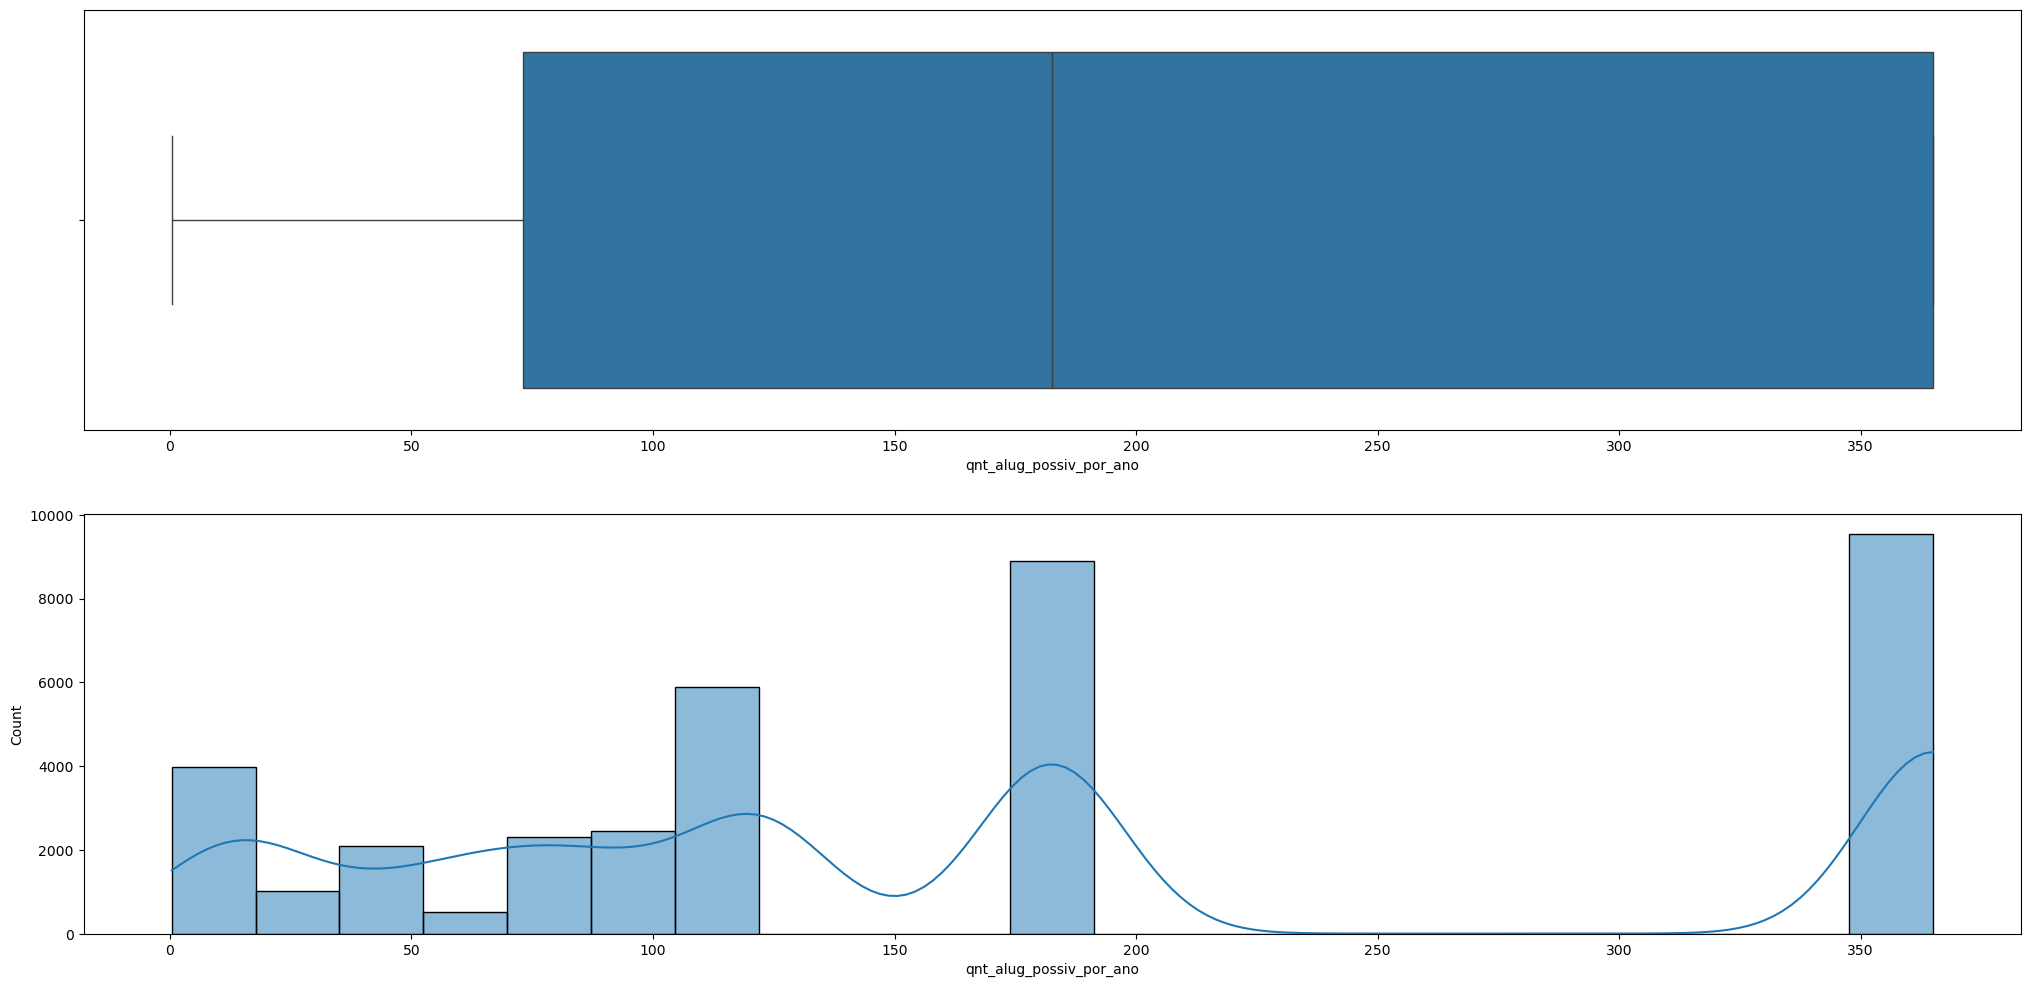

In [19]:
plt.subplot(2,1,1)
sns.boxplot(x=df5['qnt_alug_possiv_por_ano'])

plt.subplot(2,1,2)
sns.histplot(df5['qnt_alug_possiv_por_ano'], kde=True)

Não há outliers, mas a distribuição não é normal, logo, RobustScaler.

<Axes: xlabel='dias_alugados', ylabel='Count'>

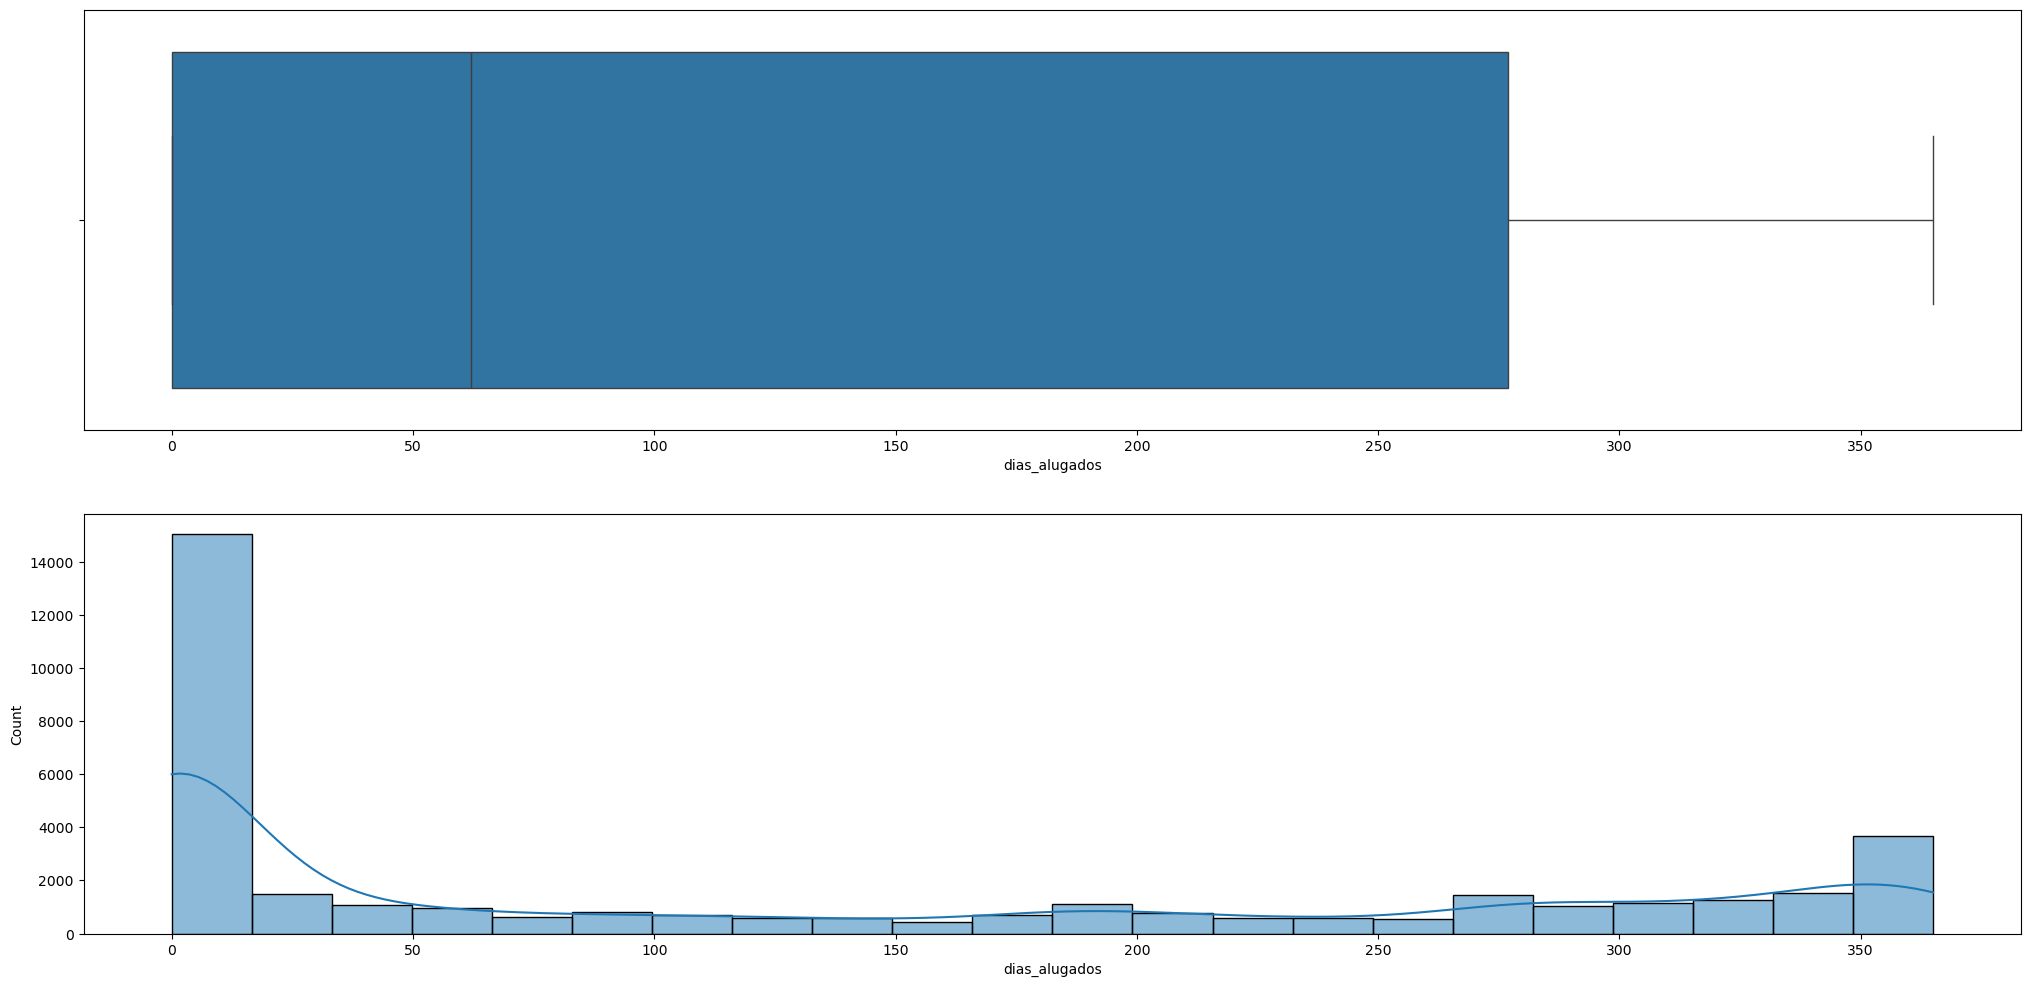

In [20]:
plt.subplot(2,1,1)
sns.boxplot(x=df5['dias_alugados'])

plt.subplot(2,1,2)
sns.histplot(df5['dias_alugados'], kde=True)

Não há outliers, mas a distribuição não é normal, logo, RobustScaler.

<br>


Tabela de resumo das técnicas de Pré-processamento a serem aplicadas nas colunas/features.

| Feature                  | Outliers | Curva Normal/Gaussiana | Pré-processamento |
|--------------------------|----------|------------------------|-----------|
| latitude                 |    ✓      |      ❌                  |     RobustScaler      |
| longitude                |     ✓    |       ❌                 |     RobustScaler      |
| minimo_noites            |     ✓     |      ❌                  |    RobustScaler       |
| numero_de_reviews        |      ✓    |      ❌                  |   RobustScaler        |
| reviews_por_mes          |     ✓     |      ❌                  |   RobustScaler        |
| host_total_listings      |      ✓    |      ❌                  |   RobustScaler        |
| disponibilidade_365      |       ✓   |      ❌                  |   RobustScaler        |
| ano                      |      ❌    |       ❌                 |  RobustScaler         |
| dias_desde_ultima_review |      ✓    |        ❌                |  RobustScaler         |
| qnt_alug_possiv_por_ano |      ❌    |      ❌                  |  RobustScaler         |
| dias_alugados            |      ❌    |        ❌                |  RobustScaler         |


In [21]:
# RobustScaler - df5
rs = RobustScaler()

cols_to_scale = ['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews', 
                 'reviews_por_mes', 'host_total_listings', 'disponibilidade_365', 
                 'ano', 'dias_desde_ultima_review', 'qnt_alug_possiv_por_ano', 
                 'dias_alugados']

# Aplique o RobustScaler nas colunas selecionadas
df5[cols_to_scale] = rs.fit_transform(df5[cols_to_scale])

# Verificando alterações
df5.select_dtypes(include=['int64', 'float64']).head()

,id,host_id,latitude,longitude,minimo_noites,numero_de_reviews,reviews_por_mes,host_total_listings,disponibilidade_365,price,ano,mes,dia,dias_desde_ultima_review,qnt_alug_possiv_por_ano,dias_alugados,distrito_peso
0,30311099,220734035,-0.27,0.26,0.25,-0.21,-0.24,0.00,-0.18,4.11,-39.67,1,1,39.09,-0.21,-0.22,4
1,17684277,119737270,-1.13,-0.07,0.00,-0.21,-0.24,1.00,-0.18,4.19,-39.67,1,1,39.09,0.00,-0.22,4
2,24208760,56905821,0.77,-0.50,0.00,1.00,1.01,0.00,-0.18,5.20,-0.33,11,20,0.04,0.00,-0.22,5
3,35616292,257879526,-0.84,0.42,0.00,-0.21,-0.24,1.00,1.37,4.01,-39.67,1,1,39.09,0.00,-0.12,4
4,5345293,27700855,-0.41,-0.91,0.00,2.38,0.52,0.00,1.08,5.71,0.00,6,30,-0.16,0.00,0.10,4


#### Rescalando e Salvando apenas as features selecionadas - Robust Scaler

In [22]:
# RobustScaler - df_to_selected_features
rs_long = RobustScaler()
rs_lat = RobustScaler()
rs_disp = RobustScaler()
rs_reviews_mes = RobustScaler()
rs_dias_desde_ultima_review = RobustScaler()
rs_n_reviews = RobustScaler()
rs_htotal_list = RobustScaler()
rs_qnt_alug_ano = RobustScaler()
rs_dias_alugados = RobustScaler()
rs_min_noites = RobustScaler()

df_to_selected_features['longitude'] = rs_long.fit_transform(df_to_selected_features[['longitude']].values)
df_to_selected_features['latitude'] = rs_lat.fit_transform(df_to_selected_features[['latitude']].values)
df_to_selected_features['disponibilidade_365'] = rs_disp.fit_transform(df_to_selected_features[['disponibilidade_365']].values)
df_to_selected_features['reviews_por_mes'] = rs_reviews_mes.fit_transform(df_to_selected_features[['reviews_por_mes']].values)
df_to_selected_features['dias_desde_ultima_review'] = rs_dias_desde_ultima_review.fit_transform(df_to_selected_features[['dias_desde_ultima_review']].values)
df_to_selected_features['numero_de_reviews'] = rs_n_reviews.fit_transform(df_to_selected_features[['numero_de_reviews']].values)
df_to_selected_features['host_total_listings'] = rs_htotal_list.fit_transform(df_to_selected_features[['host_total_listings']].values)
df_to_selected_features['qnt_alug_possiv_por_ano'] = rs_qnt_alug_ano.fit_transform(df_to_selected_features[['qnt_alug_possiv_por_ano']].values)
df_to_selected_features['dias_alugados'] = rs_dias_alugados.fit_transform(df_to_selected_features[['dias_alugados']].values)
df_to_selected_features['minimo_noites'] = rs_min_noites.fit_transform(df_to_selected_features[['minimo_noites']].values)

## 5.3 Encoding 

### 5.3.1 One Hot Encoding

Apliquei o One-Hot Encoding nas colunas seguir, pois é uma técnica para converter variáveis categóricas em números, criando uma nova coluna para cada categoria única. É adequado para variáveis com poucas categorias devido à sua simplicidade e à ausência de viés numérico. Ideal para evitar ordem entre as categorias e para conjuntos de dados onde a adição de múltiplas colunas não aumenta a dimensionalidade significativamente.

In [23]:
# Inicialize o OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)

encoded = one_hot_encoder.fit_transform(df5[['distrito', 'room_type']])

# Crie um DataFrame com as colunas codificadas
encoded_df = pd.DataFrame(encoded, columns=one_hot_encoder.get_feature_names_out(['distrito', 'room_type']))

df5.drop(['distrito', 'room_type'], axis=1, inplace=True)
df5 = pd.concat([df5, encoded_df], axis=1)

#### Encodando e Salvando apenas as features selecionadas - One Hot Encoding

In [24]:
# Inicialize o encoder
ohe_distrito = OneHotEncoder()
ohe_room = OneHotEncoder()


# Coluna distrito - ohe_distrito
# Fit transform
encoded = ohe_distrito.fit_transform(df_to_selected_features[['distrito']])
# Concatenando e dropando
df_encoded = pd.DataFrame(encoded.toarray(), columns=ohe_distrito.get_feature_names_out(['distrito']))
df_to_selected_features = pd.concat([df_to_selected_features, df_encoded], axis=1)
df_to_selected_features = df_to_selected_features.drop(columns=['distrito'])

# Coluna room_type - ohe_room
# Fit transform
encoded_b = ohe_room.fit_transform(df_to_selected_features[['room_type']])
# Concatenando e dropando
df_encoded_b = pd.DataFrame(encoded_b.toarray(), columns=ohe_room.get_feature_names_out(['room_type']))
df_to_selected_features = pd.concat([df_to_selected_features, df_encoded_b], axis=1)
df_to_selected_features = df_to_selected_features.drop(columns=['room_type'])
df_to_selected_features.head(2)

,id,nome,host_id,host_name,bairro,latitude,longitude,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,host_total_listings,disponibilidade_365,price,ano,mes,dia,dias_desde_ultima_review,qnt_alug_possiv_por_ano,dias_alugados,distrito_peso,distrito_Bronx,distrito_Brooklyn,distrito_Manhattan,distrito_Queens,distrito_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,30311099,PRIVATE ROOM IN COZY SCANDINAVIAN / BROOKLYN HOME,220734035,Selma,Williamsburg,-0.27,0.26,0.25,-0.21,1900-01-01,-0.24,0.00,-0.18,4.11,1900,1,1,39.09,-0.21,-0.22,4,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
1,17684277,Cute Private Room,119737270,Fattie,Flatbush,-1.13,-0.07,0.00,-0.21,1900-01-01,-0.24,1.00,-0.18,4.19,1900,1,1,39.09,0.00,-0.22,4,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00


### 5.3.2 Binary Encoder

Nestas colunas aqui, apliquei o Binary Encoding, pois converte muitas categorias em números binários, reduzindo a dimensionalidade do conjunto de dados. É preferível para variáveis categóricas com muitas categorias, pois economiza espaço de armazenamento e tempo de processamento, representando várias categorias em uma única coluna binária.

Obs.: Se aplicasse o One-Hot Encodingnas nas colunas a seguir, prejudiacaria o modelo devido a alta dimensionalidade, pois criaria uma coluna no dataset para cada categoria, ou seja, 100 categorias unicas, mais 100 novas colunas no dataset.

In [25]:
# BinaryEncoder
be_bairro = BinaryEncoder()

# Ajuste e transforme os dados
df_encoded = be_bairro.fit_transform(df5['bairro'])

# Concatene o DataFrame resultante com o DataFrame original
df5 = pd.concat([df5, df_encoded], axis=1)
df5 = df5.drop(columns=['bairro'])

# Evita grandes dimensionalidades o binary encondig, mas Requer tratamento de novas categorias, mas vou verificar
# se tenho todos os bairros de nyc no meu dataset aí não tem problema isso pq ele já terá mapeado todas

# be.bairro la em baixo no feature selection

### 5.3.3 Nature Transformation

Utilizei a Transformação de Natureza no dia e mês, ela captura relações não lineares entre os dados, ou seja, ela permite que o algoritmo entenda os valores como ciclos e não apenas como valores linearmente escalados. Por exemplo, temos 12 meses, de 1 a 12, dezembro(12) numericamente parece estar longe de janeiro(1), mas não é verdade, pois o mês seguinte a dezembro é janeiro. Essa transformação de natureza pode ser aplicada em tudo que tem essa ideia de ciclo, como os dias, meses, etc. 

In [26]:
# dia
df5['dia_sin'] = df5['dia'].apply(lambda x: np.sin(x * (2.* np.pi/30)))
df5['dia_cos'] = df5['dia'].apply(lambda x: np.cos(x * (2.* np.pi/30)))

# mês
df5['mes_sin'] = df5['mes'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['mes_cos'] = df5['mes'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

### 5.3.4 Droping columns

Colunas que não serão utilizadas no modelo, serão removidas

In [27]:
df5 = df5.drop(['id', 'nome', 'host_id', 'host_name', 'ultima_review'], axis=1)
df5.sample(2)

,latitude,longitude,minimo_noites,numero_de_reviews,reviews_por_mes,host_total_listings,disponibilidade_365,price,ano,mes,dia,dias_desde_ultima_review,qnt_alug_possiv_por_ano,dias_alugados,distrito_peso,distrito_Bronx,distrito_Brooklyn,distrito_Manhattan,distrito_Queens,distrito_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bairro_0,bairro_1,bairro_2,bairro_3,bairro_4,bairro_5,bairro_6,bairro_7,dia_sin,dia_cos,mes_sin,mes_cos
7654,0.22,-1.05,6.25,-0.17,-0.24,0.00,-0.18,5.30,-2.33,10,2,2.06,-0.58,-0.22,5,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0,0,0,1,0,0,0,0,0.41,0.91,-0.87,0.50
9005,-0.68,0.28,0.00,3.96,1.21,0.00,-0.18,3.61,-0.67,7,31,0.47,0.00,-0.22,4,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0,0,0,1,0,0,0,1,0.21,0.98,-0.50,-0.87


# **6.0 Feature Selection**

In [28]:
df6 = df5.copy()

Aqui utilizo técnicas de seleção de features, como o Boruta e SelecFromModel, pois identificam as melhores features do modelo. Filtrar as melhores features é importate porque reduz a dimensionalidade do conjunto de dados, torna o modelo mais simples e menos propenso a overfitting. Essas técnicas também podem melhorar o desempenho do modelo através da identificação de features irrelevantes, reduzindo o ruído nos dados. Um modelo enxuto também economiza recursos computacionais, facilitando o treino e teste.

A seguir aplico as duas técnicas para fazer um "double check" nas features mais importantes.

## 6.1 Boruta Selection

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	34
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	28
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	28
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	28
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	28
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	28
Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	28
Iteration: 	14 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	28
Iteration: 	15 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	28
Iteration: 	16 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	28
I

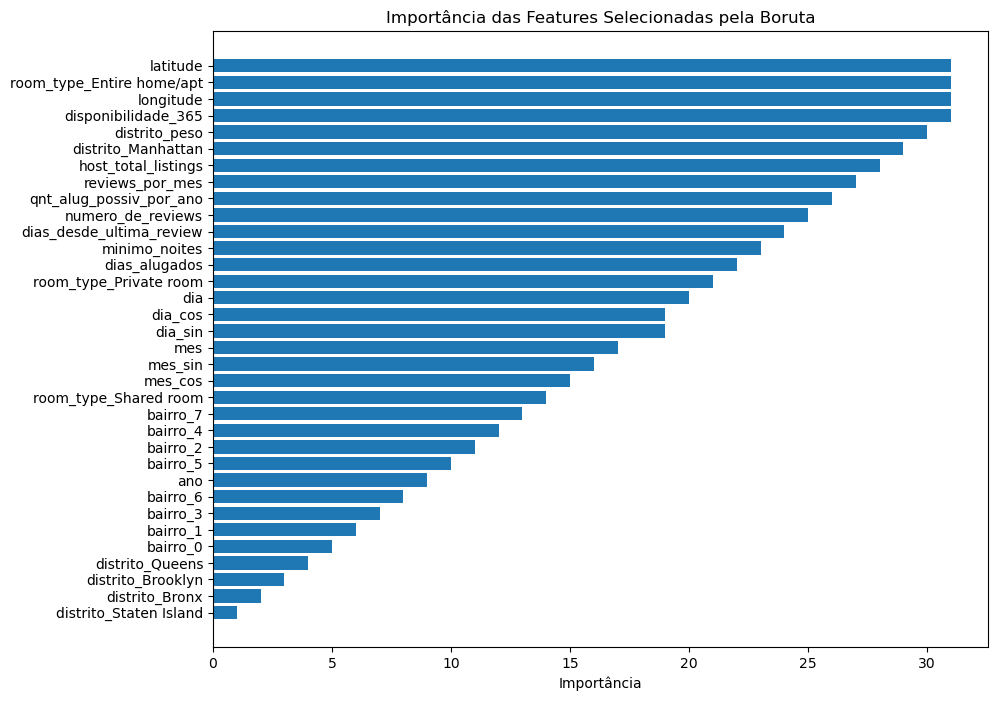



Features selecionados pelo algoritmo:
Index(['latitude', 'longitude', 'disponibilidade_365',
       'room_type_Entire home/apt'],
      dtype='object')




In [29]:
def boruta_selecting(X_train, y_train, algorithm_type):
    # Mascarando dtypes para rodar o boruta
    np.float = float   
    np.int = int
    np.object = object
    np.bool = bool


    # RODANDO BORUTA
    # Treino e teste dataset Boruta
    X_train_b = X_train.values
    y_train_b = y_train.values.ravel()

    if algorithm_type == 'regressor':
        algorithm = RandomForestRegressor(n_jobs=-1)
    if algorithm_type == 'classifier':
        algorithm = RandomForestClassifier(n_jobs=-1)

    # define Boruta
    boruta = BorutaPy(algorithm, n_estimators='auto', verbose=2, random_state=7)
    boruta.fit(X_train_b, y_train_b)


    # PLOT IMPORTANCIA DAS FEATURES
    # Obtendo as posições das features em ordem decrescente com base no ranking
    boruta.ranking_ = np.max(boruta.ranking_) - boruta.ranking_ + 1
    feature_indices = np.argsort(boruta.ranking_)[::-1]
    # Nomes das features
    feature_names = X_train.columns.tolist()
    # Obtendo as importâncias das features com base nos rankings
    feature_importances = np.sort(boruta.ranking_)[::-1]

    # Ordenando os nomes das features de acordo com os índices de importância
    feature_names_sorted = [feature_names[i] for i in feature_indices]

    # Criando o gráfico de barras horizontais com os nomes ordenados
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(feature_indices)), feature_importances)
    plt.yticks(range(len(feature_indices)), feature_names_sorted)
    plt.xlabel('Importância')
    plt.title('Importância das Features Selecionadas pela Boruta')
    plt.gca().invert_yaxis()
    plt.show()

    # SELECIONANDO FEATURES
    # Best features
    cols_selected_boruta = X_train.columns[boruta.support_]
    # Not selected boruta
    cols_not_selected_boruta = np.setdiff1d(X_train.columns, cols_selected_boruta)

    print(f'\n\nFeatures selecionados pelo algoritmo:\n{cols_selected_boruta}\n\n')

    return cols_selected_boruta, cols_not_selected_boruta

# Dataset de treino e teste para a function boruta_selecting
X_train_b = df6.drop(['price'], axis=1)
y_train_b = df6['price']

cols_selected_boruta, cols_not_selected_boruta = boruta_selecting(X_train_b, y_train_b, 'regressor')

# OBS.: Após usar o np.int = int... e usar o boruta para descobrir as features, reinicie o kernel para o np.int voltar ao normal.

## 6.2 SelectFromModel Selection

In [30]:
# Separando features e target
X_train_fs = df6.drop(['price'], axis=1).values
y_train_fs = df6['price'].values

X_train_to_see_columns_selected = df6.drop(['price'], axis=1)

# Feature Selection Model
selection_model = SelectFromModel(RandomForestRegressor(n_estimators = 100))
selection_model.fit(X_train_fs, y_train_fs)

# Features selecionadas pelo modelo
selected_feat = X_train_to_see_columns_selected.columns[(selection_model.get_support())]
print(f'As {selection_model.get_support().sum()} features mais importantes de acordo com o modelo são: {selected_feat.tolist()}')

As 4 features mais importantes de acordo com o modelo são: ['latitude', 'longitude', 'disponibilidade_365', 'room_type_Entire home/apt']


As 10 primeiras colunas mais importantes:
['distrito_Manhattan', 'distrito_peso', 'host_total_listings', 'dias_desde_ultima_review', 'numero_de_reviews', 'reviews_por_mes', 'disponibilidade_365', 'longitude', 'latitude', 'room_type_Entire home/apt']


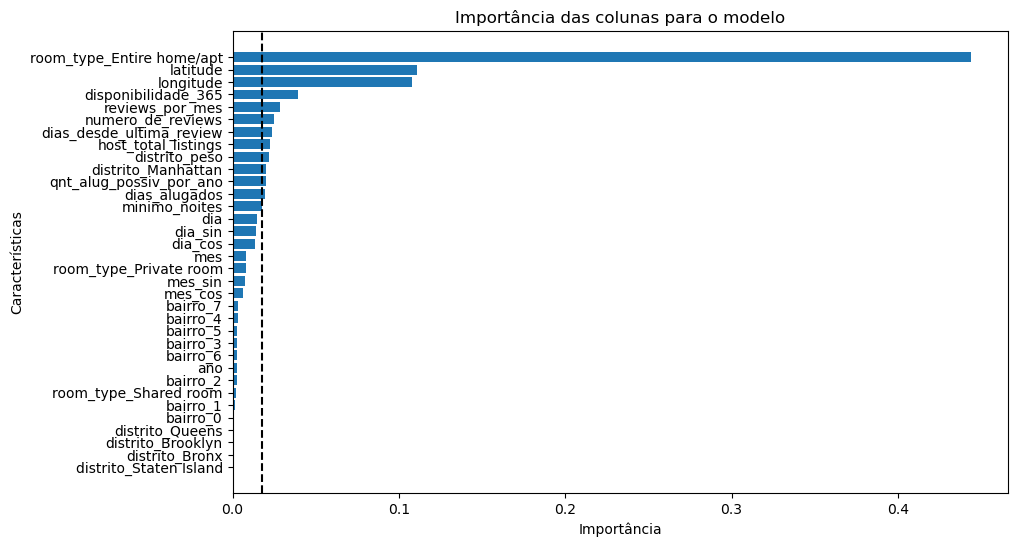

In [31]:
# Plot das % das importancias de cada coluna
importances = selection_model.estimator_.feature_importances_
feature_names = X_train_to_see_columns_selected.columns

sorted_indices = importances.argsort()
sorted_importances = importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
features_selecionadas = sorted_feature_names[-10:]
print(f'As 10 primeiras colunas mais importantes:\n{features_selecionadas}')

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Importância')
plt.ylabel('Características')
plt.title('Importância das colunas para o modelo')
plt.axvline(x=0.018, linestyle='--', color='black')
plt.show()

## 6.3 Filtrando datasets com as Features Selecionadas

In [32]:
# Selecionei algumas features a mais, além das melhores encotradas, para melhorar o entendimento para o modelo.
features_selecionadas = ['latitude', 'longitude', 'disponibilidade_365', 'distrito_Bronx', 'distrito_Brooklyn', 'distrito_Manhattan', 'distrito_Queens', 'room_type_Entire home/apt', 'room_type_Private room', 'reviews_por_mes', 'dias_desde_ultima_review', 'numero_de_reviews', 'host_total_listings', 'qnt_alug_possiv_por_ano', 'dias_alugados', 'minimo_noites', 'distrito_peso']

### 6.3.1 Treino

Aqui filtro o dataset de treino com base nas features encontradas. 

O cross validation para o desempenho do modelo será feito utilizando este dataset de treino que é dividio em k folds, a função está presente no tópico helper functions, no início do notebook.

In [33]:
# TREINO
x_train = df_to_selected_features[features_selecionadas]
y_train = df_to_selected_features['price']

### 6.3.2 Teste

Abaixo encotra-se todas as funções para tratamento do dataset de teste como limpeza dos dados, feature engineering e rescaling/encoding.

Lembrando que durante o rescaling e encoding do teste, utilizemos os rescaling/encoding salvos apenas com o transform, para evita vazamento de dados (data leakage). 

In [34]:
# Funções de tratamento do dataset de teste raw
def cleaning_dataset(df):
    # Alterando nomes de algumas colunas
    df['bairro_group'].unique()
    df.rename(columns={'bairro_group': 'distrito', 'calculado_host_listings_count': 'host_total_listings'}, inplace=True)

    # Filling NAN
    # Coluna host_name preencida com NI (Não informado)
    df['host_name'] = df['host_name'].fillna('NI')
    # Coluna nome preencida com NI (Não informado)
    df['nome'] = df['nome'].fillna('NI')
    # Coluna ultima_review preenchida com data muito no passado/futuro
    df['ultima_review'] = df['ultima_review'].fillna('1900-01-01')
    # Coluna reviews_por_mes preenchida com 0 - (pelo visto, é a média das reviews, mas por mês, resultando em valores decimais)
    # Se Nan, adicionei 0, pois não possui review alguma, nota-se a coluna ultima_review com a mesma quantidade de NAN.
    df['reviews_por_mes'] = df['reviews_por_mes'].fillna(0)

    # Covertendo para data
    df['ultima_review'] = pd.to_datetime(df['ultima_review'])

    # Removando valores de preço muito baixos ou 0
    df['price'] = df['price'].apply(lambda x: 120 if x == 0 else 32 if x < 32 else x)
    df = df[df['price'] <= 339]
    df.reset_index(drop=True, inplace=True)

    print(f'Valores NANs: {df.isna().sum().sum()} (cleaning_dataset function)')
    return df
def feature_eng(df):
    # FEATURE: ano, mês, dia 
    # Objetivo: verificar se há sazonalidades nos meses, anos e dias.
    df['ano'] = df['ultima_review'].dt.year
    df['mes'] = df['ultima_review'].dt.month
    df['dia'] = df['ultima_review'].dt.day

    # FEATURE: recencia das reviews 
    # Objetivo: verificar quantos dias se passaram desde a última review (quanto maior o valor de dias, pior, considerando que, se houve review, é porque ocorreu uma hospedagem/negócio)
    # Nota: Valores na 'dias_desde_ultima_review' de 43652 referem-se as datas de 1900-01-01, utilizadas para o preenchimento de NAN na coluna 'ultima_review'.
    ultima_data = df['ultima_review'].max()
    df['dias_desde_ultima_review'] = (ultima_data - df['ultima_review']).dt.days

    # FEATURE: quantidade possível máxima de se alugar o imóvel por ano, considerando apenas o mínimo de noites
    # Objetivo: identificar a flexibilidade de aluguel do imóvel
    # Nota: se o mínimo de noites for maior 365 dias, só pode ser alugado uma vez por ano ou menos. 
    df['qnt_alug_possiv_por_ano'] =  365 / df['minimo_noites'] 

    # FEATURE: desempenho do quão requisitado foi o imóvel durante o ano
    # Objetivo: verificar o desempenho através da disponibilidade_365 (dias restantes)
    # Nota: quanto mais próximo de zero, melhor para o imóvel, pois mostra que foi bem requisitado, talvez influenciando no preço. 
    #       Por exemplo: 365 dias do ano - 65 dias disponiveis = 300 dias alugados, logo o imóvel foi bem requisitado.
    df['dias_alugados'] = df['disponibilidade_365'].apply(lambda x: (365 - x) if x > 0 and x <= 364 else x) # else x, para casos como, disponibilidade365 = 365 ou 0.

    # FEATURE: peso dos preços dos distritos
    # Objetivo: identificar distritos mais caros
    # Nota: Ordenei a feature de acordo com os valores das medianas vistas no boxplot da hipótese 6.
    mapeamento_distrito_peso = {
    'Bronx': 1,
    'Queens': 2,
    'Staten Island': 3,
    'Brooklyn': 4,
    'Manhattan': 5}
    df['distrito_peso'] = df['distrito'].map(mapeamento_distrito_peso)
    
    print(f'Valores NANs: {df.isna().sum().sum()} (feature_eng function)')
    return df  
def rescaling_encoding(df):
    # Rescaling
    # RobustScaler
    df['longitude'] = rs_long.transform(df[['longitude']].values)
    df['latitude'] = rs_lat.transform(df[['latitude']].values)
    df['disponibilidade_365'] = rs_disp.transform(df[['disponibilidade_365']].values)
    df['reviews_por_mes'] = rs_reviews_mes.transform(df[['reviews_por_mes']].values)
    df['dias_desde_ultima_review'] = rs_dias_desde_ultima_review.transform(df[['dias_desde_ultima_review']].values)
    df['numero_de_reviews'] = rs_n_reviews.transform(df[['numero_de_reviews']].values)
    df['host_total_listings'] = rs_htotal_list.transform(df[['host_total_listings']].values)
    df['qnt_alug_possiv_por_ano'] = rs_qnt_alug_ano.transform(df[['qnt_alug_possiv_por_ano']].values)
    df['dias_alugados'] = rs_dias_alugados.transform(df[['dias_alugados']].values)
    df['minimo_noites'] = rs_min_noites.transform(df[['minimo_noites']].values)
    
    # Encoding
    # Fit transform - Coluna distrito - ohe_distrito
    encoded = ohe_distrito.transform(df[['distrito']])
    # Concatenando e dropando
    df_encoded = pd.DataFrame(encoded.toarray(), columns=ohe_distrito.get_feature_names_out(['distrito']))
    df = pd.concat([df, df_encoded], axis=1)
    df = df.drop(columns=['distrito'])

    # Fit transform - Coluna room_type - ohe_room
    encoded = ohe_room.transform(df[['room_type']])
    # Concatenando e dropando
    df_encoded = pd.DataFrame(encoded.toarray(), columns=ohe_room.get_feature_names_out(['room_type']))
    df = pd.concat([df, df_encoded], axis=1)
    df = df.drop(columns=['room_type'])

    print(f'Valores NANs: {df.isna().sum().sum()} (rescaling_encoding function)')
    return df

Aqui importo o dataset de teste que foi divido no tópico "0.3 Splitting dataset" e chamo as funções para aplicar os tramentos citados acima.

In [35]:
# TESTE
x_test_raw = pd.read_csv('../datasets/raw_datasets/test_raw_from_split_train.csv')

# Limpezas e Feature Engineering
df_aux_test = cleaning_dataset(x_test_raw)
df_aux_test = feature_eng(df_aux_test)
# Rescaling e Encoding
df_aux_test = rescaling_encoding(df_aux_test)
# Filtrando - feature selection 
x_test = df_aux_test[features_selecionadas]
y_test = df_aux_test['price'] # não precisa aplicar exp1, pois não foi normalizado.

print(f'Dataset x_test com ({len(features_selecionadas)}) colunas.')

Valores NANs: 0 (cleaning_dataset function)
Valores NANs: 0 (feature_eng function)
Valores NANs: 0 (rescaling_encoding function)
Dataset x_test com (17) colunas.


# **7.0 Machine Learning**

Cada modelo é treinado e testado uma vez apenas com treino e teste, apenas para identificar a linearidade do modelo e ter uma ideia do desempenho deles, nos subtópicos de cada modelo, obtenho as performances utilizando o método de cross validation presente no tópico "helper functions". Por fim crio duas tabelas de resumo, uma com performance singular do modelo e outra com real performance (cross validation).

Nota: É importante realizar a validação cruzada, pois permite que o algoritmo seja treinado e testado em diversos cenários dentro do conjunto de dados. Contar exclusivamente com uma única execução de treino e teste não é ideal para avaliar o desempenho do modelo, pois os resultados podem ser influenciados pela aleatoriedade dos dados em uma única divisão. A validação cruzada oferece uma avaliação mais robusta, considerando múltiplas divisões dos dados, garantindo uma avaliação mais precisa e confiável do modelo.

## 7.1 Modelo de Média

O modelo de média será nosso baseline (ponto de referência inicial) para comparar e avaliar o desempenho de modelos mais complexos.

Os modelos de machine learning serão minimamente aceitáveis se possuirem um desempenho melhor que o baseline.

In [36]:
# Média da coluna target
media_y_test = y_test.mean()
# Coluna yhat_baseline com todas as linhas com o mesmo valor da média
yhat_baseline  = pd.Series([media_y_test] * len(y_test))
baseline_result = ml_error('Average Model', y_test, yhat_baseline)
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,55.08,0.63,67.89


## 7.2 Linear Regression Model

In [37]:
lr = LinearRegression()
lr.fit(x_train, y_train)
yhat = lr.predict(x_test)
lr_result = ml_error('Linear Regression', y_test, np.expm1(yhat))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,34.67,0.31,49.32


### 7.2.1 Linear Regression Model - Cross Validation

In [38]:
lr_result_cv = cross_validation('Linear Regression', LinearRegression(), x_train, y_train, 5)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,34.83 +/- 0.461906,0.31 +/- 0.002136,49.32 +/- 0.53271


## 7.3 Linear Regression Regularized Model - Lasso

In [39]:
lss = Lasso(alpha=0.01).fit(x_train, y_train)
yhat = lss.predict(x_test)
lss_result = ml_error( 'Linear Regression - Lasso', y_test, np.expm1(yhat))
lss_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,35.79,0.32,50.62


### 7.3.1 Lasso - Cross Validation

In [40]:
lss_result_cv = cross_validation('Lasso', Lasso(), x_train, y_train, 5)
lss_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,52.96 +/- 0.209926,0.522 +/- 0.005212,69.69 +/- 0.182436


## 7.4 Decision Tree Regressor

In [41]:
dtree = DecisionTreeRegressor()
dtree.fit(x_train, y_train)
yhat = dtree.predict(x_test)
dtree_result = ml_error('Decision Tree Regressor', y_test, np.expm1(yhat))
dtree_result.round(3)

,Model Name,MAE,MAPE,RMSE
0,Decision Tree Regressor,43.26,0.39,62.60


### 7.4.1 Decision Tree Regression - Cross Validation

In [42]:
dtree_result_cv = cross_validation('Decision Tree Regressor', DecisionTreeRegressor(), x_train, y_train, 5)
dtree_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Decision Tree Regressor,43.34 +/- 0.787773,0.396 +/- 0.006012,61.86 +/- 0.854023


## 7.5 Random Forest Regressor

In [43]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train )
yhat = rf.predict(x_test)
rf_result = ml_error('Random Forest Regressor', y_test,  np.expm1(yhat))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,30.96,0.27,44.96


### 7.5.1 Random Forest Regressor - Cross Validation

In [44]:
rf_result_cv = cross_validation('Random Forest Regressor', rf, x_train, y_train, 5)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,31.0 +/- 0.576812,0.271 +/- 0.004892,44.81 +/- 0.637424


## 7.6 XGBoost Regressor

In [45]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta = 0.3,
                             max_depth=6,
                             subsample=1,
                             colsample_bytree=1).fit(x_train, y_train)
yhat = model_xgb.predict(x_test)
xgb_result = ml_error('XGBoost Regressor', y_test, np.expm1(yhat))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,30.63,0.27,44.40


### 7.6.1 XGBoost Regressor - Cross Validation

In [46]:
xgb_result_cv = cross_validation('XGBoost', model_xgb, x_train, y_train, 5)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,31.02 +/- 0.458885,0.27 +/- 0.003308,44.82 +/- 0.462589


## 7.7 Comparing Model's Performance

### 7.7.1 Single Performance

In [47]:
single_model_result = pd.concat([baseline_result, lr_result, lss_result, dtree_result, rf_result, xgb_result])
round(single_model_result.sort_values('RMSE'), 3)

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,30.63,0.27,44.40
0,Random Forest Regressor,30.96,0.27,44.96
0,Linear Regression,34.67,0.31,49.32
0,Linear Regression - Lasso,35.80,0.32,50.62
0,Decision Tree Regressor,43.26,0.39,62.60
0,Average Model,55.08,0.63,67.89


### 7.7.2 Real Performance - CV

In [48]:
cv_model_result = pd.concat([lr_result_cv, lss_result_cv, dtree_result_cv,rf_result_cv, xgb_result_cv])
cv_model_result.sort_values('MAPE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,31.02 +/- 0.458885,0.27 +/- 0.003308,44.82 +/- 0.462589
0,Random Forest Regressor,31.0 +/- 0.576812,0.271 +/- 0.004892,44.81 +/- 0.637424
0,Linear Regression,34.83 +/- 0.461906,0.31 +/- 0.002136,49.32 +/- 0.53271
0,Decision Tree Regressor,43.34 +/- 0.787773,0.396 +/- 0.006012,61.86 +/- 0.854023
0,Lasso,52.96 +/- 0.209926,0.522 +/- 0.005212,69.69 +/- 0.182436


# **8.0 Hyperparameter Fine Tuning**

Na etapa de fine-tuning, otimizamos os hiperparâmetros do melhor algoritmo encontrado, para maximizar o desempenho do modelo. 

Existem três técnicas comuns de fine-tuning que podemos utilizar: o Grid Search que percorre todas as possbilidades, o Random Search que percorre aleatoriamente, e a Otimização Bayesiana que utiliza métodos probabilísticos.Aqui utilizarei o Random Search por ser mais rápido e exigir menos recurso computacional.

Lembrando que o fine tuning melhora o desempenho do modelo, mas em pequeno valor, o que realmente melhora a performance são features bem construídas que passam informações relevantes para o algoritmo.

## 8.1 Random Search

In [49]:
param = {
        'n_estimators': [1500, 1700, 2500, 3000, 3500],
        'eta': [0.01, 0.03],
        'max_depth': [3, 5, 9],
        'subsample': [0.1, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.7, 0.9],
        'min_child_weight': [3, 8, 15]
        }
max_eval = 10
final_result = pd.DataFrame()

for i in range(max_eval):
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()} 
    print(hp)

    # model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                n_estimators = hp['n_estimators'],
                                eta = hp['eta'],
                                max_depth = hp['max_depth'],
                                subsample = hp['subsample'],
                                colsample_bytree = hp['colsample_bytree'],
                                min_child_weight = hp['min_child_weight'])

    result = cross_validation('XGBoost Regressor', model_xgb, x_train, y_train, 5)
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,30.55 +/- 0.483839,0.265 +/- 0.003614,44.27 +/- 0.510514
0,XGBoost Regressor,30.98 +/- 0.496556,0.269 +/- 0.003581,44.72 +/- 0.546482
0,XGBoost Regressor,31.44 +/- 0.547746,0.273 +/- 0.003435,45.45 +/- 0.667432
0,XGBoost Regressor,31.05 +/- 0.470052,0.27 +/- 0.003148,44.89 +/- 0.575869
0,XGBoost Regressor,31.32 +/- 0.515559,0.273 +/- 0.003154,45.25 +/- 0.624254
0,XGBoost Regressor,30.82 +/- 0.463374,0.268 +/- 0.003481,44.57 +/- 0.51242
0,XGBoost Regressor,31.14 +/- 0.505001,0.271 +/- 0.003127,45.04 +/- 0.617839
0,XGBoost Regressor,31.47 +/- 0.54695,0.274 +/- 0.00333,45.49 +/- 0.670511
0,XGBoost Regressor,31.05 +/- 0.486392,0.27 +/- 0.003178,44.92 +/- 0.585313
0,XGBoost Regressor,31.49 +/- 0.541952,0.274 +/- 0.003317,45.5 +/- 0.670809


## 8.2 Final Model

In [59]:
# Melhores hiperparametros encontrados 
param_tuned = {'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}

In [60]:
# Treianando o melhor modelo encontrado com os melhores hiperparametros
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                    n_estimators = param_tuned['n_estimators'],
                                    eta = param_tuned['eta'],
                                    max_depth = param_tuned['max_depth'],
                                    subsample = param_tuned['subsample'],
                                    colsample_bytree = param_tuned['colsample_bytree'],
                                    min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

xgb_result_tuned = ml_error('XGBoost Regressor', y_test, np.expm1(yhat_xgb_tuned)) 
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,30.28,0.26,44.02


In [61]:
# Salvando o modelo xgb tunado
pickle.dump(model_xgb_tuned, open('/Users/andre/repos/Processos_seletivos/indicium/pkl_model/model_imoveis.pkl', 'wb'))

# 9.0 Tradução e Interpretação do Erro

Nesta etapa, eu analiso o desempenho do modelo e faço a tradução dos valores do modelo de machine learning para valor de negócio.

In [62]:
df9 = df_aux_test.copy()

In [63]:
# Retornando preço predito para valores originais. Obs.: df9['price'] já no valor original
df9['price_prediction'] = np.expm1(yhat_xgb_tuned)

# Erro Predito vs Real
df9['price_medio'] = df9['price'].mean()
df9['baseline_error'] = df9['price_medio'] - df9['price']
df9['error'] = df9['price_prediction'] - df9['price']

# Error Rate
df9['error_rate'] = df9['price_prediction'] / df9['price']
df9['error_rate_baseline'] = df9['price_medio'] / df9['price']

# APE
df9['APE'] = (df9['error'] / df9['price'])*100
df9['APE'] = df9['APE'].abs().round(2)

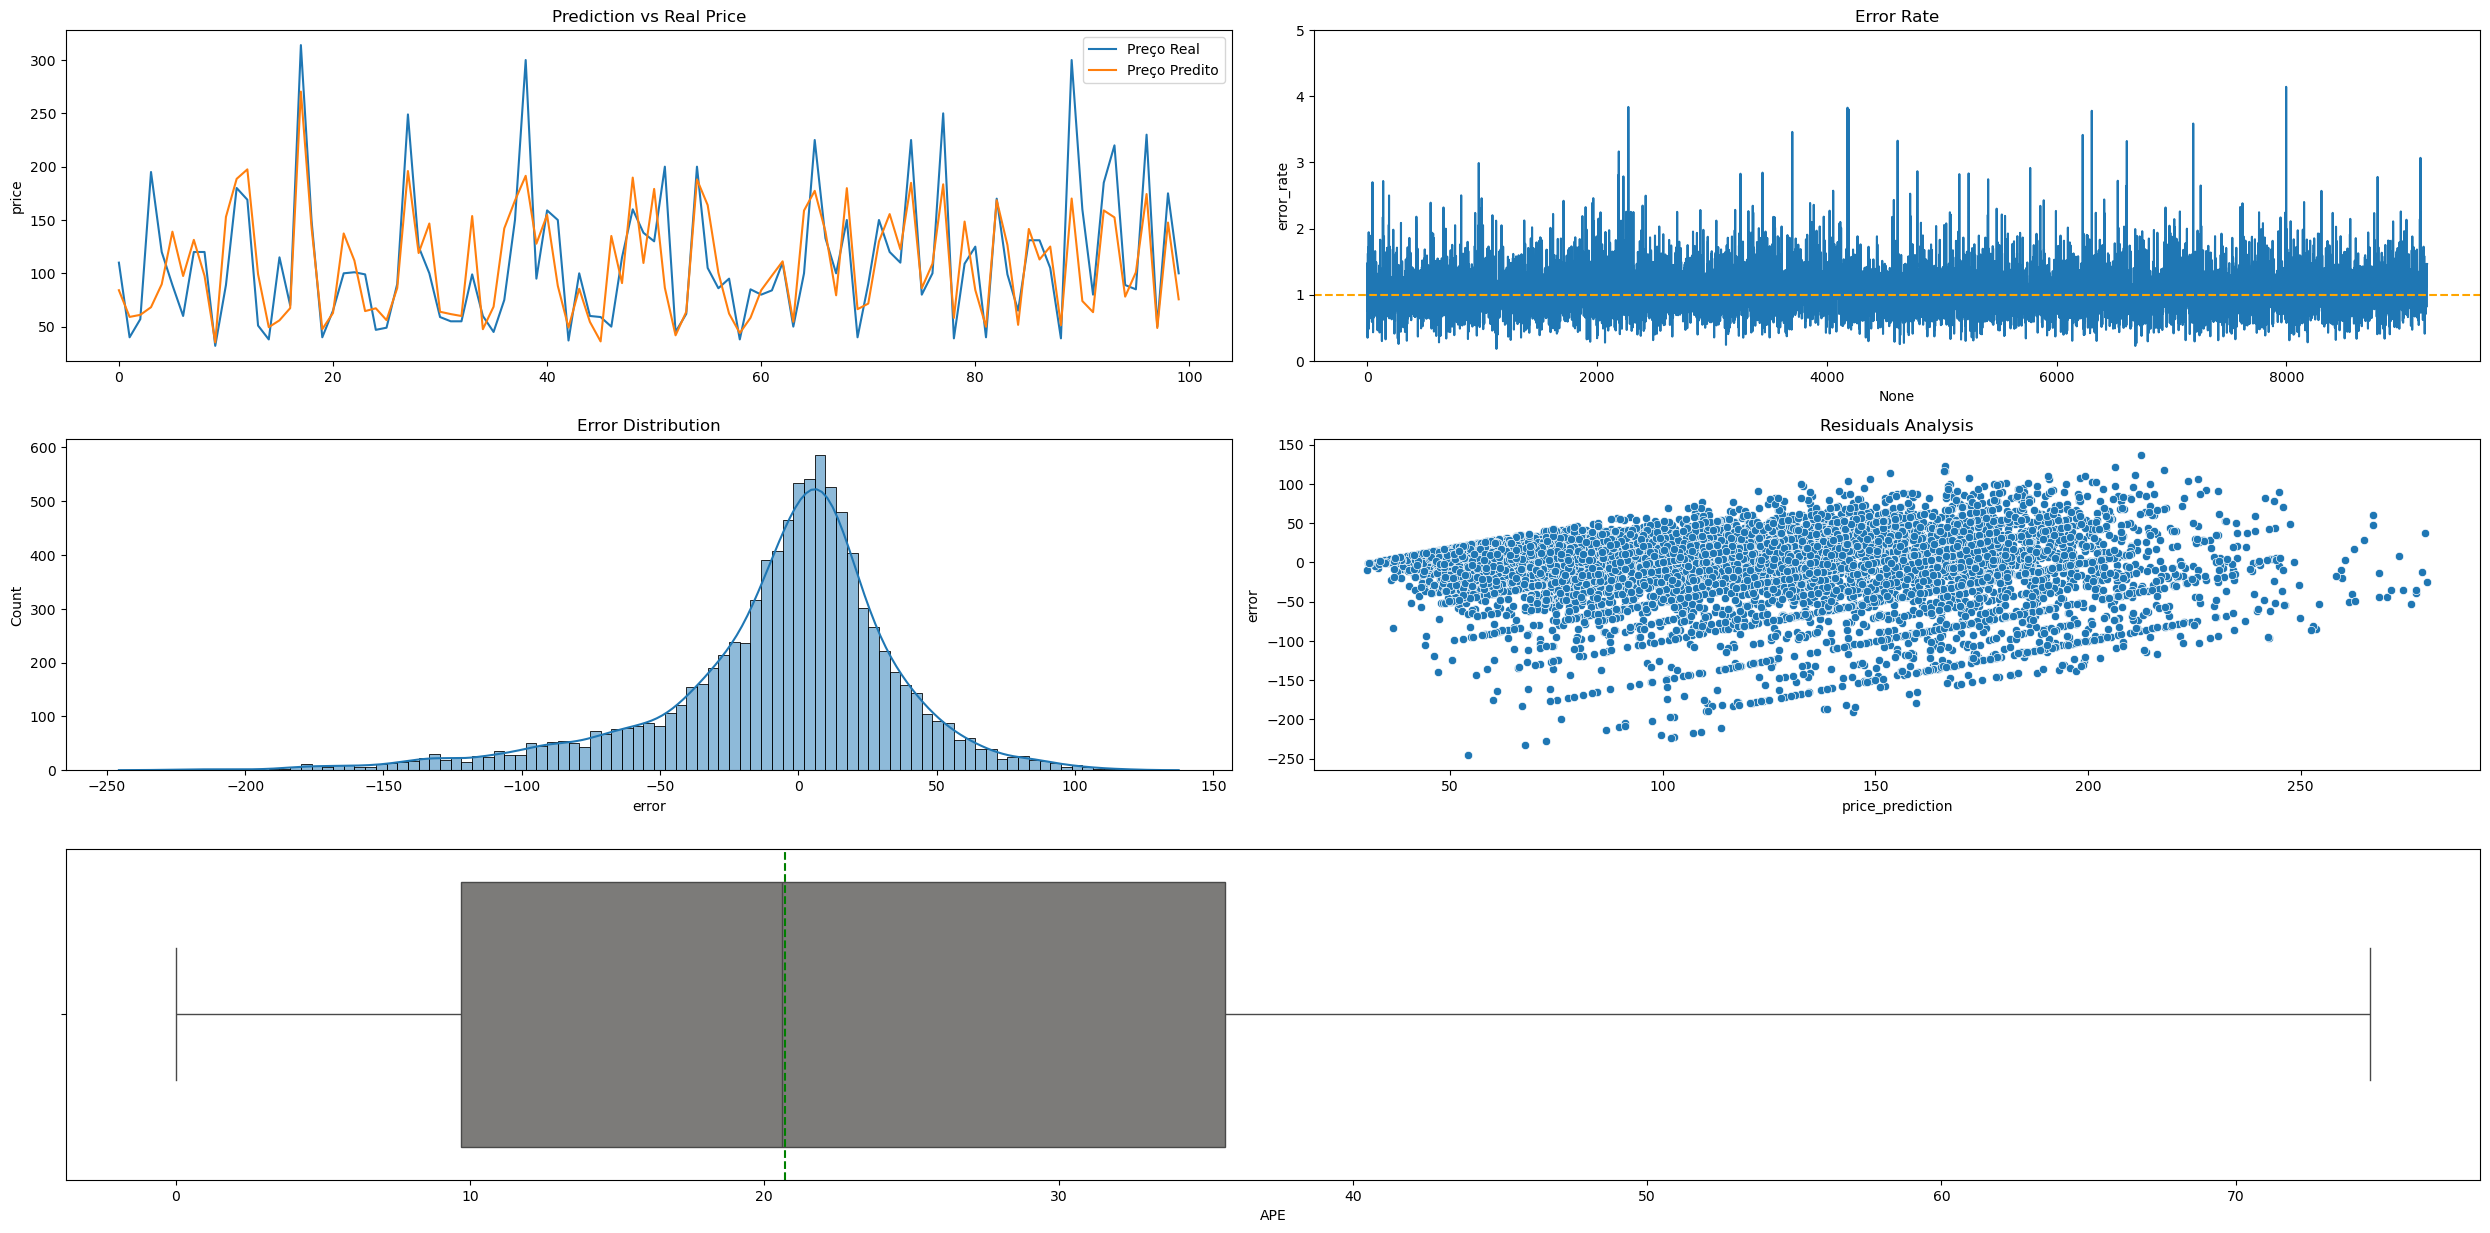

In [70]:
# Plots 
grid = gridspec.GridSpec(3, 2)
plt.figure(figsize=(25,12))

# Plot Erro Predito vs Real
plt.subplot(grid[0,0])
plt.title('Prediction vs Real Price')
sns.lineplot(x=range(0,100), y='price', data=df9.iloc[0:100], label='Preço Real')
sns.lineplot(x=range(0,100), y='price_prediction', data=df9.iloc[0:100], label='Preço Predito')
plt.legend()

# Plot Error Rate
plt.subplot(grid[0,1])
plt.title('Error Rate')
sns.lineplot(x=df9.index, y='error_rate', data=df9)
plt.ylim(0,5)
plt.axhline(1, linestyle='--', c='orange')

# Plot Error Distribution
plt.subplot(grid[1,0])
plt.title('Error Distribution')
# sns.distplot(df9['error'])
sns.histplot(df9['error'], kde=True)

# Plot Residuals Analysis
plt.subplot(grid[1,1])
plt.title('Residuals Analysis')
sns.scatterplot(x = 'price_prediction', y = 'error', data=df9.loc[df9['price_prediction']<9**6])
plt.tight_layout()

# Plot error each row
plt.subplot(grid[2,:])
sns.boxplot(x=df9['APE'], showfliers=False, palette='cividis')
plt.axvline(20.7, linestyle='--', c='green')
plt.show()

Além dos outros gráficos que nos mostram o desempenho do modelo, dois possuem informações interessantes:

 - O boxplot nos mostra que 50% das predições estão com um erro abaixo dos 20,7%.

 - O Gráfico de análise de resíduos, nos mostra um spray/cone dos valores dos erros a medida que aumenta os valores preditos, ou seja, o modelo possui um desempenho melhor em acertar valores menores. O ideal seria que os pontos formassem um formato mais retangular, pois assim não teria uma variação muito grande dos erros do modelo, estaria mais consistente.

# 10.0 Prevendo preço do imóvel solicitado

In [71]:
# Dados fornecidos
data = {'id': 2595,
        'nome': 'Skylit Midtown Castle',
        'host_id': 2845,
        'host_name': 'Jennifer',
        'bairro_group': 'Manhattan',
        'bairro': 'Midtown',
        'latitude': 40.75362,
        'longitude': -73.98377,
        'room_type': 'Entire home/apt',
        'price': 225,
        'minimo_noites': 1,
        'numero_de_reviews': 45,
        'ultima_review': '2019-05-21',
        'reviews_por_mes': 0.38,
        'calculado_host_listings_count': 2,
        'disponibilidade_365': 355}

# Criar DataFrame
imovel_solicitado = pd.DataFrame(data, index=[0])

## 10.1 Tratando dados

In [72]:
# Limpezas e Feature Engineering
imovel_solicitado = cleaning_dataset(imovel_solicitado )
imovel_solicitado = feature_eng(imovel_solicitado)

# Rescaling e Encoding
imovel_solicitado = rescaling_encoding(imovel_solicitado)

# Filtrando - feature selection 
x_test_imovel = imovel_solicitado[features_selecionadas]
y_test_imovel = imovel_solicitado['price'] # não precisa aplicar exp1, pois não foi normalizado.

print(f'Dataset x_test com ({len(features_selecionadas)}) colunas.')

Valores NANs: 0 (cleaning_dataset function)
Valores NANs: 0 (feature_eng function)
Valores NANs: 0 (rescaling_encoding function)
Dataset x_test com (17) colunas.


## 10.2 Prevendo o preço

In [73]:
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                    n_estimators = param_tuned['n_estimators'],
                                    eta = param_tuned['eta'],
                                    max_depth = param_tuned['max_depth'],
                                    subsample = param_tuned['subsample'],
                                    colsample_bytree = param_tuned['colsample_bytree'],
                                    min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)
yhat_xgb_tuned = model_xgb_tuned.predict(x_test_imovel)
print(f'Valor sugerido para o imóvel: {yhat_xgb_tuned}')

Valor sugerido para o imóvel: [5.3243866]
